<a href="https://colab.research.google.com/github/CIS-522/course-content/blob/W2T2/tutorials/W2_PyTorchDLN/W2_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-522 Week 2 Part 2
# Deep Linear Networks

__Instructor:__ Konrad Kording

__Content creators:__ Ameet Rahane, Spiros Chavlis

---
# Today's agenda

In the second tutorial of Week 2, we are going to dive deep into the Linear Networks. One can see Linear Networks as the core models of Deep Learning; they are simple, mathematically easily interpretable, and of course fun. Today we will:

1. Construct our first models in pytorch using core modules
2. Solve the XOR logical operation, which is linearly non-separable, with a linear network
3. Investigate the initialization of our parameters
4. Examine how the network actual learns
5. Learn about different loss functions and we can use them efficiently
6. Give an intuition about the high dimensional spaces, the essense of Deep Learning.

Are you ready?

In [ ]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = 'value' #@param {type:"string"}
my_pod = 'sublime-newt' #@param ['Select', 'euclidean-wombat', 'sublime-newt', 'buoyant-unicorn', 'lackadaisical-manatee','indelible-stingray','superfluous-lyrebird','discreet-reindeer','quizzical-goldfish','astute-jellyfish','ubiquitous-cheetah','nonchalant-crocodile','fashionable-lemur','spiffy-eagle','electric-emu','quotidian-lion']


# start timing
import time
try:t0;
except NameError: t0 = time.time()



In [ ]:
# intro video
from IPython.display import YouTubeVideo

---
# Setup

In [ ]:
# imports
import numpy as np
import random
import matplotlib.pylab as plt
import matplotlib as mpl
import pandas as pd
from tqdm.notebook import tqdm, trange
import time

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder


# For regression with neural data
!pip install spykes --quiet
!pip install deepdish deepdish
from spykes.plot.neurovis import NeuroVis
from spykes.io.datasets import load_reaching_data
from spykes.utils import train_test_split

In [ ]:
# @title Figure Settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline 

fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})

plt.rcParams["mpl_toolkits.legacy_colorbar"] = False

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/"
              "course-content/master/nma.mplstyle")


In [ ]:
#@title Helper functions

def synthetic_dataset(w, b, num_examples=1000, sigma=0.01, seed=2021):
  '''
  Synthetic data generator in the form:
      y = Xw + b + gaussian_noise(0, sigma).
  
  Parameters
  ----------
  w : torch.tensor
      weights. The length of `w` denotes the number of independent variables
  b : torch.tensor
      bias (offset or intercept).
  num_examples : INT, optional
      DESCRIPTION. The default is 1000.
  sigma : FLOAT, optional
      Standard deviation of the Gaussian noise. The default is 0.01.
  seed : INT, optional
      Seed the RNG for reproducibility. The default is 2021.
  
  Returns
  -------
  X: torch.tensor
      the independent variable(s).
  y: torch.tensor
      the dependent variable
  
  '''

  torch.manual_seed(seed)

  X = torch.normal(0, 1, (w.shape[0], num_examples))
  y = torch.matmul(w.T, X) + b
  # Add gaussian noise
  y += torch.normal(0, sigma, y.shape)
  if y.shape[0]==1:
      y = y.reshape((-1, 1))

  return X, y


def XOR_plots(activ_l1):
  from mpl_toolkits.axes_grid1 import AxesGrid
  fig = plt.figure()
  fig.subplots_adjust(left=0.05, right=0.95)
  grid = AxesGrid(fig, 111,  # similar to subplot(142)
                  nrows_ncols=(2, 5),
                  axes_pad=0.1,
                  share_all=False,
                  label_mode="1",
                  cbar_location="right",
                  cbar_mode="single",
                  )

  for i in range(2*5):
    im = grid[i].imshow(activ_l1[:, i].reshape(30,30), cmap='RdBu')

  grid.cbar_axes[0].colorbar(im)

  for cax in grid.cbar_axes:
      cax.toggle_label(False)
    
  grid.axes_llc.set_xticks([0, 14, 29])
  grid.axes_llc.set_yticks([0, 14, 29])
  grid.axes_llc.set_xticklabels(['-1.1', '0', '1.1'])
  grid.axes_llc.set_yticklabels(['-1.1', '0', '1.1'])


  fig, axes = plt.subplots(nrows=2, ncols=5)
  cnt = 0
  for ax in axes.flat:
    ax.plot(np.sum(inputs.cpu().detach().numpy(), axis=1),
            activ_l1[:,cnt], '.')
    cnt += 1
  plt.tight_layout()



def XORpredictions(inputs, targets, preds):
  print('\nTest the model on XOR logical operation...')
  for input, target, pred in zip(inputs, targets, preds):
    print("Input:[{},{}] Target:[{}] Predicted:[{}] Error:[{}]".format(
      int(input[0]),
      int(input[1]),
      int(target[0]),
      round(float(pred[0]), 4),
      round(float(abs(target[0] - pred[0])), 4)
    ))


def plotRegression(X, y, preds, losses, losses_xavier=None):
  plt.figure()
  plt.subplot(1, 2, 1)
  plt.plot(losses, label='gaussian init.')
  if losses_xavier:
    plt.plot(losses_xavier, label='Xavier init.')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('Training loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.scatter(X.T, y.reshape(-1,1), label='original data')
  plt.plot(X.T, preds.detach().numpy(), label='regression',
          color='red', linewidth=3.0)
  plt.xlabel('independent variable')
  plt.ylabel('dependent variable')
  plt.title(f'Toy dataset, {N} samples')
  plt.legend()
  plt.show()


def plot_weight(losses, weights):
  plt.figure()
  plt.subplot(1, 2, 1)
  plt.plot(losses)
  plt.xlabel('epoch')
  plt.ylabel('loss')

  plt.subplot(1, 2, 2)
  plt.plot(weights[0], label='Layer 1')
  plt.plot(weights[1], label='Layer 2')
  plt.plot(weights[2], label='Layer 3')
  plt.xlabel('epoch')
  plt.ylabel('weight')
  plt.legend()
  plt.show()


def plot_learning_modes(losses, epochs, modes, rank):
  plt.figure()
  plt.subplot(1, 2, 1)
  plt.plot(losses)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('Training loss')

  plt.subplot(1, 2, 2)
  plt.plot(range(epochs), modes.T)
  plt.legend(range(1,rank+1))
  plt.xlabel('epoch')
  plt.ylabel('loading [a.u.]')
  plt.show()


def getData():
  # Download the dataset
  reach_data = load_reaching_data()

  print('dataset keys:', reach_data.keys())
  print('events:', reach_data['events'].keys())
  print('features', reach_data['features'].keys())
  print('number of PMd neurons:', len(reach_data['neurons_PMd']))


  # Get reach direction, ensure it is between [-pi, pi]
  y = np.arctan2(np.sin(reach_data['features']['endpointOfReach'] *
                np.pi / 180.0),
                np.cos(reach_data['features']['endpointOfReach'] *
                np.pi / 180.0))

  # Let's put the data into a DataFrame
  #
  # Events
  data_df = pd.DataFrame()
  events = ['targetOnTime', 'goCueTime', 'rewardTime']

  for i in events:
    data_df[i] = np.squeeze(reach_data['events'][i])


  data_df[events].head()

  ########################################################
  # Extract M1 spike counts Y
  # ~~~~~~~~~~~~~
  # - Select only neurons above a threshold firing rate
  # - Align spike counts to the GO cue
  # - Use the convenience function ```get_spikecounts()``` from ```NeuroVis```

  # Select only high firing rate neurons
  M1_select = list()
  threshold = 10.0

  # Specify timestamps of events to which trials are aligned
  align = 'goCueTime'

  # Specify a window of around the go cue for spike counts
  window = [0., 500.]  # milliseconds

  # Get spike counts
  X = np.zeros([y.shape[0], len(reach_data['neurons_M1'])])

  for n in range(len(reach_data['neurons_M1'])):
    this_neuron = NeuroVis(spiketimes=reach_data['neurons_M1'][n])
    X[:, n] = np.squeeze(
        this_neuron.get_spikecounts(event=align,
                                    df=data_df,
                                    window=window))

    # Short list a few high-firing neurons
    if this_neuron.firingrate > threshold:
      M1_select.append(n)

  # Rescale spike counts to units of spikes/s
  X = X / float(window[1] - window[0]) * 1e3

  ########################################################
  # Split into train and test sets (2/3 training, 1/3 test)
  # ~~~~~~~~~~~~~

  (x_train, x_test), (y_train, y_test) = train_test_split(X, y, percent=0.20)

  return (x_train, y_train, x_test, y_test)


def loss_comparison(lossesMSE, lossesMAE, MSE_test, MAE_test):
  plt.figure()
  plt.plot(lossesMSE, label='MSE')
  plt.plot(lossesMAE, label='MAE')
  plt.xlabel('epoch')
  plt.ylabel('loss [a.u.]')
  plt.legend()
  plt.show()

  print("\nErrors in the test set using both models")
  print (f"Test set: using L1 loss function (MAE): {MAE_test}")
  print (f"Test set: L2 loss function (MSE): {RMSE_test}")


def idx_word(docs):
  '''
  Function to give an index to every word found in doc

  Parameters
  ----------
  docs : list of STR
      Contains the text

  Returns
  -------
  idx_2_word : dictionary
      assign an index to every word.
  word_2_idx : dictionary
      assign a word to every index.

  '''
  idx_2_word = {}
  word_2_idx = {}
  temp = []
  i = 1
  for doc in docs:
    for word in doc.split():
      if word not in temp:
        temp.append(word)
        idx_2_word[i] = word
        word_2_idx[word] = i
        i += 1
        
  return (idx_2_word, word_2_idx)


def one_hot_map(doc, word_2_idx):
  '''
  Translate each document `doc` into a vector with integers
  Parameters
  ----------
  doc : STR
      The text to be translated.

  Returns
  -------
  x : LIST
      Sentence in INTEGER format.

  '''
  x = []
  for word in doc.split():
    x.append(word_2_idx[word])
  return x


def combinations(lst):
  index = 1
  pairs = []
  for element1 in lst:
    for element2 in lst[index:]:
      pairs.append([element1, element2])
    index += 1

  return pairs

In [ ]:
# @title Set seed for reproducibility
seed = 2021
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

print ('Seed has been set.')

Seed has been set.


---
# Section 1: Deep linear networks
# How they can be seen as an approximation to DL later in the course.

Video available at https://youtube.com/watch?v=Yy68K5STSMA


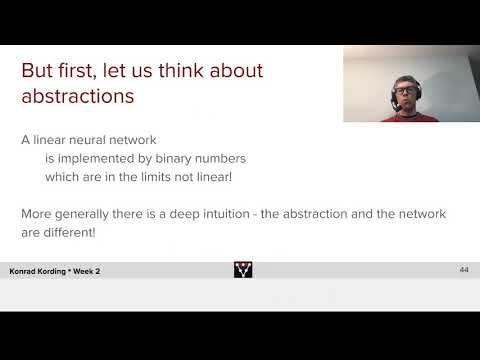

In [ ]:
#@title Video: Deep Learning, the Abstraction and the Implementation

import time
try: t0;
except NameError: t0=time.time()

video = YouTubeVideo(id="Yy68K5STSMA", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

Now that we have verified that pytorch works as expected (!!!), we will use pytorch to implement our models.

## Exercise 1: Construct a Linear Neural Network
First, we will use `nn.Sequential` class to construct our model as a function. You may use `? nn.Sequential` in a *scratch cell* to see its Docstring. 

`nn.Sequential` is a container of Modules which will be added to it in the order they are passed in the constructor. Alternatively, an ordered dict of modules can also be passed in.

```python
# Example of using Sequential
model = nn.Sequential(
          nn.Linear(15,15),
          nn.Conv2d(15,10),
          nn.Linear(10,8)
        )
```

In [ ]:
# Build a 2 layer linear network using nn.Sequential model

input_dim = 1
output_dim = 1
hidden_1 = 10
hidden_2 = 10

def model(input_dim, output_dim, hidden_1, hidden_2):
  ####################################################################
  # Fill in missing code below (...),
  # then remove or comment the line below to test your function
  raise NotImplementedError("Add the hidden layers")
  ####################################################################  
  net = nn.Sequential(nn.Linear(input_dim, hidden_1),
                      ...,
                      ...)
  return (net)

## uncomment the line below to test your function
# my_net = model(input_dim, output_dim, hidden_1, hidden_2)
# print(my_net)

In [ ]:
# to_remove solution

input_dim = 1
output_dim = 1
hidden_1 = 10
hidden_2 = 10

def model(input_dim, hidden_1, hidden_2, output_dim):
  net = nn.Sequential(nn.Linear(input_dim, hidden_1),
                      nn.Linear(hidden_1, hidden_2),
                      nn.Linear(hidden_2, output_dim))
  return (net)


my_net = model(input_dim, hidden_1, hidden_2, output_dim)
print(my_net)

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)


## Exercise 2: Construct the same network using `nn.Module` class
Another approach, is to write a custom class (`nn.Module`). This approach lets us implement custom NN functions and provides more flexibility and better handling.

`nn.Module` is a base class for all neural network modules. Your models should also subclass this class. Modules can also contain other Modules, allowing to nest them in a tree structure. You can assign the submodules as regular attributes.

```python
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(10, 20)
        self.linear2 = nn.Linear(20, 1)

    def forward(self, x):
        x = self.linear1(x)
        return self.linear1(x)

```

In this example we have created a Model with two layers.

In [ ]:
#@markdown What are the dimension of:
sequential = '' #@param {type:"string"}

Now is your time to write some lines of code.

In [ ]:
# Build a 3 layer linear network using nn.Module class

class Net(nn.Module):

  def __init__(self, input_dim, hidden_1, hidden_2, output_dim):
    super(Net, self).__init__()

    self.input_dim = input_dim
    self.hidden_1 = hidden_1
    self.hidden_2 = hidden_2
    self.output_dim = output_dim

    # Create 3 FCN (fully-connected layers)
    self.fc1 = nn.Linear(self.input_dim, self.hidden_1)
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Define the two hidden layers")
    ####################################################################
    self.fc2 = ...
    self.fc3 = ...

  def forward(self, x):
    h1 = self.fc1(x)
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Calculate the forward pass")
    ####################################################################
    h2 = ...
    out = ...

    return out

## uncomment the line below to test your function
# my_net2 = Net(input_dim, hidden_1, hidden_1, output_dim)
# print(my_net2)

In [ ]:
# to_remove solution

class Net(nn.Module):

  def __init__(self, input_dim, hidden_1, hidden_2, output_dim):
    super(Net, self).__init__()

    self.input_dim = input_dim
    self.hidden_1 = hidden_1
    self.hidden_2 = hidden_2
    self.output_dim = output_dim

    # Create 3 FCN (fully-connected layers)
    self.fc1 = nn.Linear(self.input_dim, self.hidden_1)
    self.fc2 = nn.Linear(self.hidden_1, self.hidden_2)
    self.fc3 = nn.Linear(self.hidden_2, self.output_dim)

  def forward(self, x):
    h1 = self.fc1(x)
    h2 = self.fc2(x)
    out = self.fc3(h2)

    return out


my_net2 = Net(input_dim, hidden_1, hidden_1, output_dim)
print(my_net2)

Net(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)


Please feel free to implement the network using any other approach that is more comfortable for you!

---
# Section 2: How linear networks are not linear.


Video available at https://youtube.com/watch?v=9qPwfWlAsOM


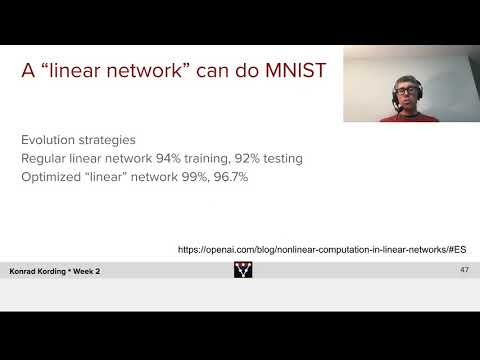

In [ ]:
#@title Video: Solving XOR with Linear Neural Networks

import time
try: t1;
except NameError: t1=time.time()

video = YouTubeVideo(id="9qPwfWlAsOM", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

Here, we are going to show that one can use a linear NN (without any nonlinearity) and solve a nonlinear problem. We focus on the XOR problem, i.e., a logical operation with linear nonseparable data!

Exclusive OR (XOR) logical operation gives a true (`1`) output when the number of true inputs is odd, that is, a true output results if one, and only one, of the inputs to the gate is true. If both inputs are false (`0`) or both are true, a false (`0`) output results. Mathematically speaking, XOR represents the inequality function, i.e., the output is true if the inputs are not alike otherwise the output is false.

In case of two inputs ($X$ and $Y$) the following truth table is applied:

\begin{array}{ccc}
X & Y & \text{XOR} \\
\hline
0 & 0 & 0 \\
0 & 1 & 1 \\
1 & 0 & 1 \\
1 & 1 & 0 \\
\end{array}

Here, with `0` we denote `False`, and with `1` we denote `True` in boolean terms.

But, how we are going to solve a linear nonseparable dataset without using a nonlinearity?

We will show that deep linear networks, which are implemented using floating-point arithmetic, are not actually linear and can perform nonlinear computation! Without any nonlinearity, consecutive linear layers would be, in theory, mathematically equivalent to a single linear layer. So, it is a surprise that floating point arithmetic is nonlinear enough to yield trainable deep networks.

Numbers used by computers aren’t perfect mathematical numbers but approximate representations using finite numbers of bits. Computers commonly use *floating-point* numbers to represent mathematical objects. Each *floating-point* number is represented by a combination of a fraction and an exponent. In the IEEE’s float32 standard, 23 bits are used for the fraction and 8 for the exponent, and one for the sign.

The linear network will consist of 3 layer; the input layer; a hidden layer; and the output layer.

First, we want to see if we can push the network in a regime where linear operations become non-linear. Thus, we construct a data set with $X$ and $Y$ variables in the range $[-1.1, 1.1]$.


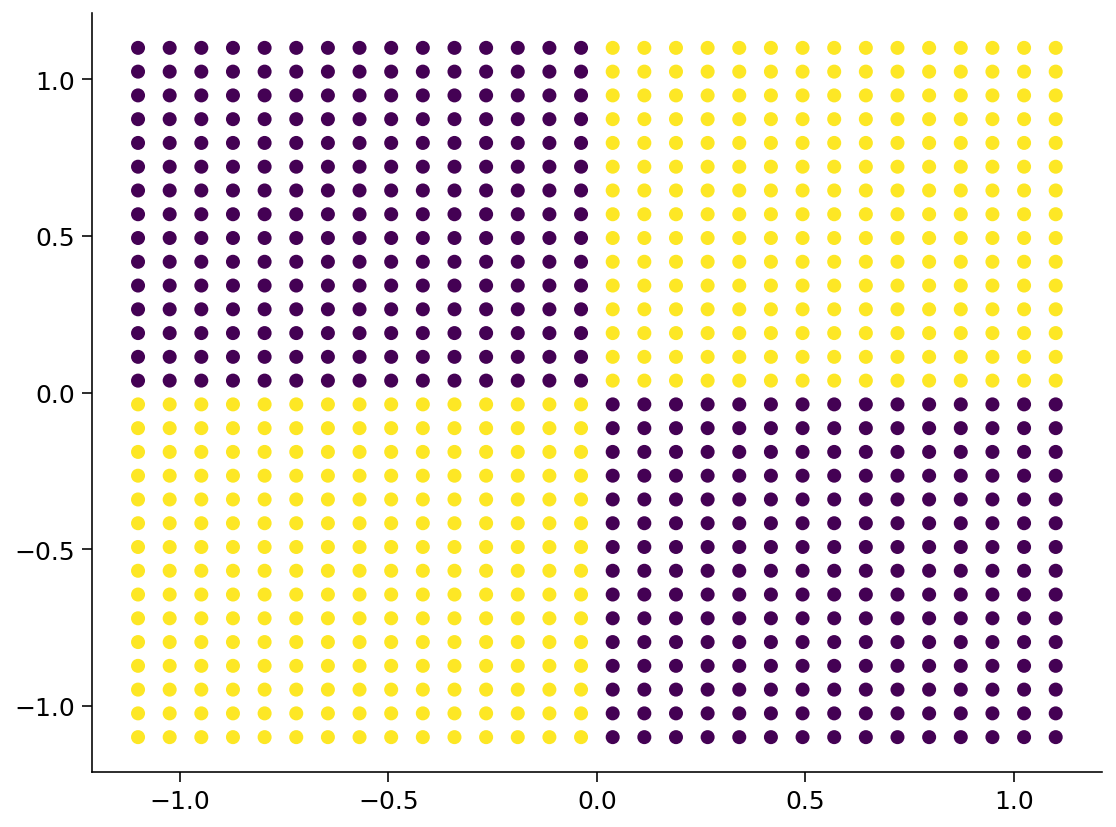

In [ ]:
# enable denormals in pytorch to take advantage of the non-linear effects
torch.set_flush_denormal(True)

# generating the data set
X = np.linspace(start=-1.1, stop=1.1, num=30)
Y = np.linspace(start=-1.1, stop=1.1, num=30)

inputs = np.array(np.meshgrid(X, Y)).T.reshape(-1, 2)
targets = np.ones(shape=(900, 1))
targets[inputs[:, 0]*inputs[:, 1] < 0] = -1.

inputs = inputs.astype(np.float32)
targets = targets.astype(np.float32)

# Convert inputs and targets to tensors
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

# print(inputs)
plt.figure()
plt.scatter(inputs.detach().cpu().numpy()[:, 0],
            inputs.detach().cpu().numpy()[:, 1], c=targets)
plt.show()

Now, let's implement the linear network from scratch. We do this, since it gives us better handling, and because we are going to use a weird scaling operation!

Lets initialize the parameters. Notice that we do not use learnable parameters (`requires_grad=False`) in the first layer.

In [ ]:
# Initial Weights and biases

input_dim = inputs.shape[1]
output_dim = targets.shape[1]
hidden1, hidden2 = 10, 1

w1 = Variable(torch.mul(torch.randn(hidden1, input_dim), np.sqrt(1/input_dim)),
              requires_grad=False)
b1 = Variable(torch.mul(torch.randn(hidden1), 0.0),
              requires_grad=False)

w2 = Variable(torch.mul(torch.randn(hidden2, hidden1), np.sqrt(1/hidden1)),
              requires_grad=True)
b2 = Variable(torch.mul(torch.randn(hidden2), 0.0),
              requires_grad=True)

params = [w1, b1, w2, b2]

## Exercise 3: Define a crazy scaling and plot the output of the hidden layer

*Hint:* You have to scale down weights and biases to very small values to exploit the non linearity. Try different values to verify that the network is linear, apart from a range of values where scaling is very, very big.

In [ ]:
# Crazy scaling

# Define the model - custom based to have better handling

def model(x, params):
  ####################################################################
  # Fill in missing code below (...),
  # note that parameters are divided by the scaling factor
  # then remove or comment the line below to test your function
  raise NotImplementedError("Choose the scaling wisely!")
  ####################################################################
  scaling = ...

  w1, b1, w2, b2 = params[0], params[1], params[2], params[3]
  h1 = (x @ w1.t()/scaling + b1/scaling)
  out = (h1 @ w2.t() + b2/scaling) * scaling
  return out, h1

## uncomment the lines below to test your choice
# out = model(inputs, params)
# activ_l1 = out[1]
# XOR_plots(activ_l1)

/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


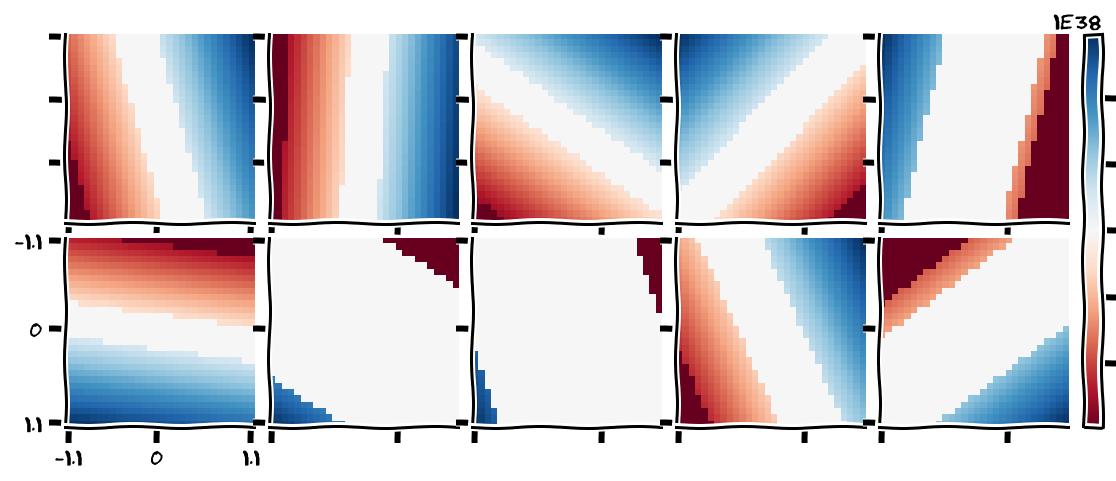

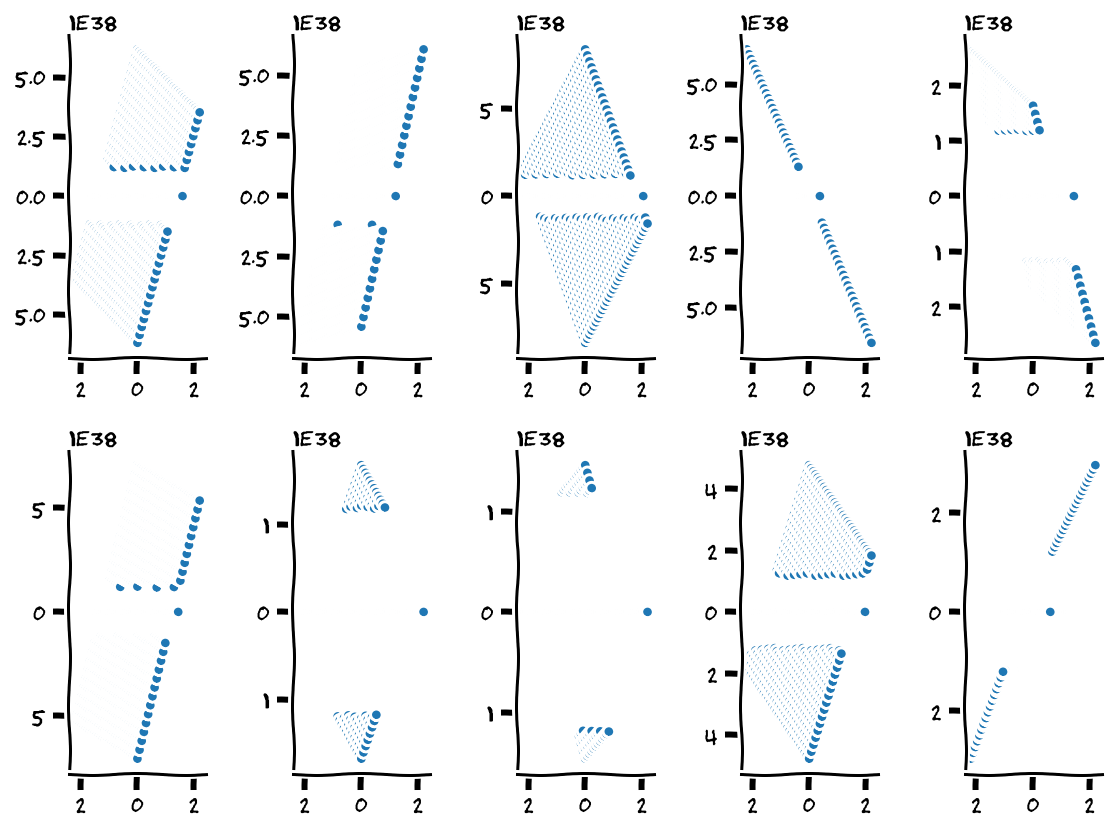

In [ ]:
# to_remove solution

# Crazy scaling

# Define the model - custom based to have better handling
def model(x, params):
  scaling = torch.tensor(2**124, dtype=torch.float32)

  w1, b1, w2, b2 = params[0], params[1], params[2], params[3]
  h1 = (x @ w1.t()/scaling + b1/scaling)
  out = (h1 @ w2.t() + b2/scaling) * scaling
  return out, h1


out = model(inputs, params)
activ_l1 = out[1]
with plt.xkcd():
  XOR_plots(activ_l1)

In [ ]:
#@markdown Can you give a value at which the nonlinearity kicks-in?
xor = '' #@param {type:"string"}

How can we push the network to operate in nonlinear regime using the binary inputs in order to solve XOR? First, we construct the dataset consisting of 4 input vectors and four target values, as the one given in the table above.

In [ ]:
# Construct the input data
inputs = np.array([
                   [0., 0.],
                   [0., 1.],
                   [1., 0.],
                   [1., 1.]
                   ])
targets = np.array([
                    [0.],
                    [1.],
                    [1.],
                    [0.]
                    ])

# set the input in float32 type
inputs = inputs.astype(np.float32)
targets = targets.astype(np.float32)

# Convert inputs and targets to tensors
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

## Exercise 4: Solve XOR logical operation

In order to take advantage of the non linearity, inspect carefully the plots above and choose bias in order to move the emerging non linearity to $[0,1]$ range.

In [ ]:
# Show how a deep linear network can wrongly solve xor

def solveXOR(inputs, targets, seed=2021):

  # Network dimensions
  input_dim = inputs.shape[1]
  output_dim = targets.shape[1]
  hidden1, hidden2 = 1000, 1

  # Initial Weights and biases
  torch.manual_seed(seed)
  w1 = Variable(torch.mul(torch.randn(hidden1, input_dim), np.sqrt(1/input_dim)),
                requires_grad=False)
  ####################################################################
  # Fill in missing code below (...),
  # then remove or comment the line below to test your function
  raise NotImplementedError("Initialize bias wisely")
  ####################################################################
  b1 = ...

  w2 = Variable(torch.mul(torch.randn(hidden2, hidden1), np.sqrt(1/hidden1)),
                requires_grad=True)
  b2 = Variable(torch.mul(torch.randn(hidden2), 1.0),
                requires_grad=True)
  
  params = [w1, b1, w2, b2]

  # Training loop parameters
  lr  = 2e-4  # learning rate
  epochs = 250  # total epochs
  criterion = nn.MSELoss()  # loss function

  # Train for epochs
  losses = []

  epoch_range = trange(epochs, desc='loss: ', leave=True)

  for epoch in epoch_range:
    if losses:
      epoch_range.set_description("loss: {:.6f}".format(losses[-1]))
      epoch_range.refresh() # to show immediately the update
    time.sleep(0.01)

    out = model(inputs, params)
    loss = criterion(out[0], targets)
    loss.backward()
      
    # Adjust weights & reset gradients
    with torch.no_grad():
      # Gradient descent
      w2 -= w2.grad * lr
      b2 -= b2.grad * lr
      # flush gradients
      w2.grad.zero_()
      b2.grad.zero_()
        
    losses.append(loss)

  # make the predictions
  return (model(inputs, params))


## uncomment the lines below to test your function
# outputs = solveXOR(inputs, targets) 
# XORpredictions(inputs.cpu().detach().numpy(),
#                targets.cpu().detach().numpy(),
#                predictions[0].cpu().detach().numpy())

In [ ]:
# to_remove solution

# Show how a deep linear network can wrongly solve xor

def solveXOR(inputs, targets, seed=2021):

  # Network dimensions
  input_dim = inputs.shape[1]
  output_dim = targets.shape[1]
  hidden1, hidden2 = 1000, 1

  # Initial Weights and biases
  torch.manual_seed(seed)
  w1 = Variable(torch.mul(torch.randn(hidden1, input_dim), np.sqrt(1/input_dim)),
                requires_grad=False)
  b1 = Variable(torch.mul(torch.randn(hidden1), 2.0),
                requires_grad=False)

  w2 = Variable(torch.mul(torch.randn(hidden2, hidden1), np.sqrt(1/hidden1)),
                requires_grad=True)
  b2 = Variable(torch.mul(torch.randn(hidden2), 1.0),
                requires_grad=True)
  
  params = [w1, b1, w2, b2]

  # Training loop parameters
  lr  = 2e-4  # learning rate
  epochs = 250  # total epochs
  criterion = nn.MSELoss()  # loss function

  # Train for epochs
  losses = []

  epoch_range = trange(epochs, desc='loss: ', leave=True)

  for epoch in epoch_range:
    if losses:
      epoch_range.set_description("loss: {:.6f}".format(losses[-1]))
      epoch_range.refresh() # to show immediately the update
    time.sleep(0.01)

    out = model(inputs, params)
    loss = criterion(out[0], targets)
    loss.backward()
      
    # Adjust weights & reset gradients
    with torch.no_grad():
      # Gradient descent
      w2 -= w2.grad * lr
      b2 -= b2.grad * lr
      # flush gradients
      w2.grad.zero_()
      b2.grad.zero_()
        
    losses.append(loss)

  # make the predictions
  return (model(inputs, params))


outputs = solveXOR(inputs, targets)
XORpredictions(inputs.cpu().detach().numpy(),
               targets.cpu().detach().numpy(),
               outputs[0].cpu().detach().numpy())



Test the model on XOR logical operation...
Input:[0,0] Target:[0] Predicted:[0.0] Error:[0.0]
Input:[0,1] Target:[1] Predicted:[1.0224] Error:[0.0224]
Input:[1,0] Target:[1] Predicted:[1.102] Error:[0.102]
Input:[1,1] Target:[0] Predicted:[-0.0] Error:[0.0]


Hooray! You have solved XOR with a pure Linear Neural Network!

In [ ]:
#@markdown Do you think this answer is correct or is a hack?
xor_solution = '' #@param {type:"string"}

---
# Section 3: Back to actual linear neural networks
# Lets make it deep (should have no effect, right?)

Video available at https://youtube.com/watch?v=5w9byiqPeO0


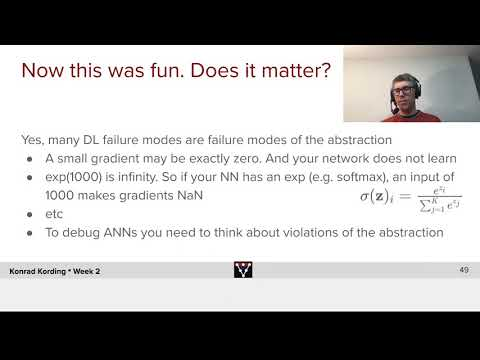

In [ ]:
#@title Video: Deep Linear ANNs

import time
try: t2;
except NameError: t2=time.time()

video = YouTubeVideo(id="5w9byiqPeO0", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

Firts, we construct our toy dataset which consists of independent variables in 1D space in order to make the illustartion easier. Let's construct the dataset and then plot it.

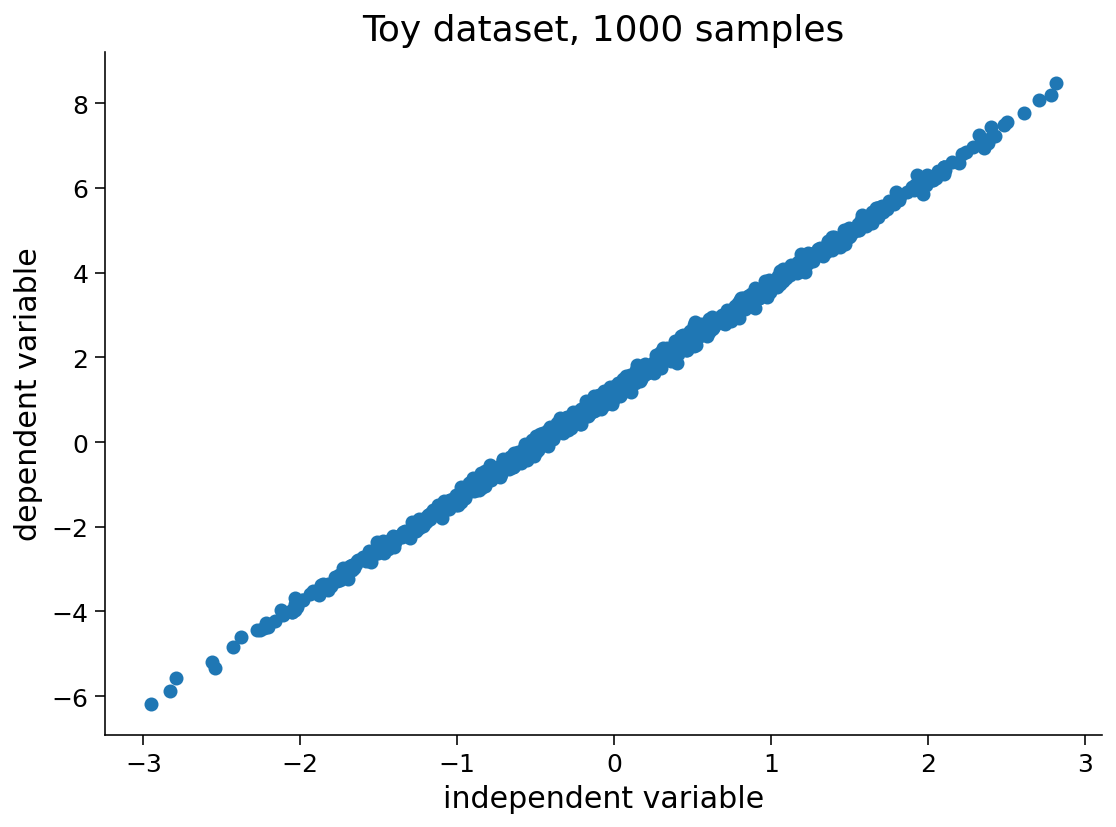

In [ ]:
# Dataset

original_w = torch.tensor([2.5]).reshape(-1,1)
original_b = 1.2
N = 1000  # number of examples
X, y = synthetic_dataset(original_w, original_b, num_examples=1000,
                         sigma=0.1, seed=2021)


plt.figure()
plt.scatter(X.T, y)
plt.xlabel('independent variable')
plt.ylabel('dependent variable')
plt.title(f'Toy dataset, {N} samples')
plt.show()

First, we will construct a Linear Regression model (one input and one output), similar to W2T1. We initialize the parameters very close to zero. Run the cell and see what happens.


The loss after training is: 0.00994585920125246


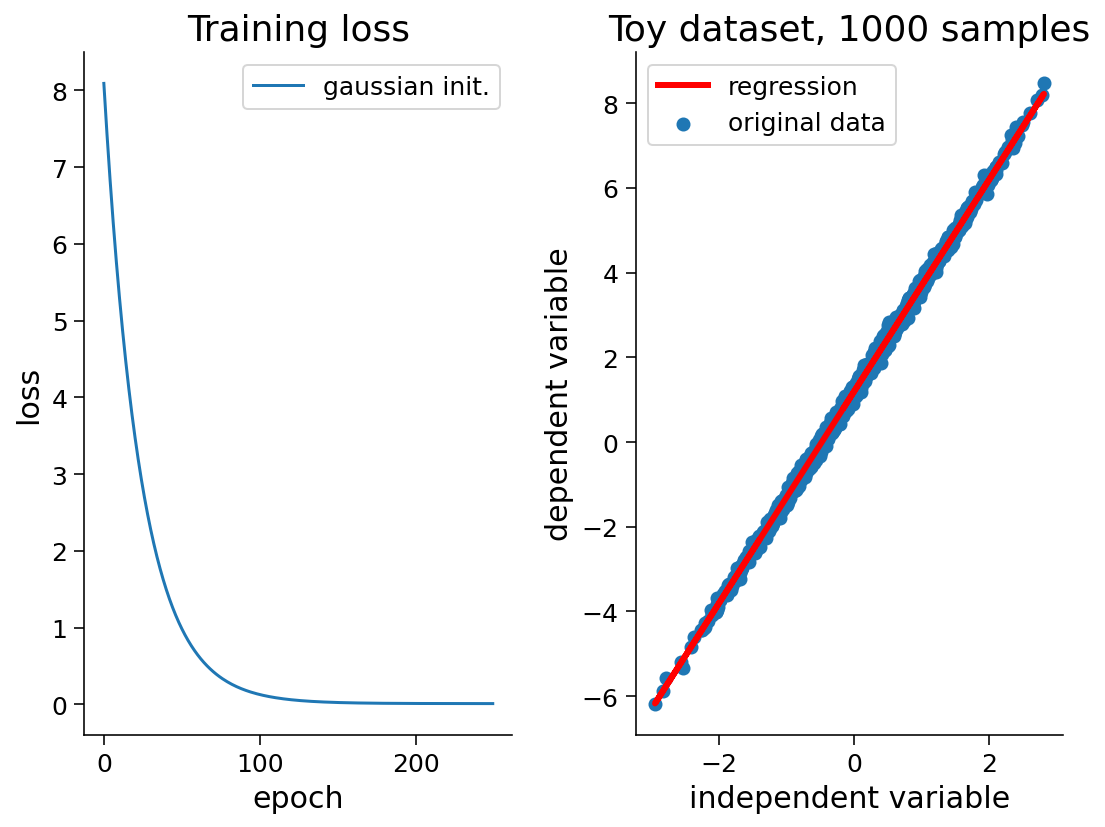

In [ ]:
def deepNetwork(deep=False):
  # Network parameters
  input_dim = 1
  output_dim = 1

  if deep:
    h1, h2, h3, h4, h5, h6 = 20, 15, 10, 5, 4, 2
    # define our network
    net = nn.Sequential(nn.Linear(input_dim, h1),
                        nn.Linear(h1, h2),
                        nn.Linear(h2, h3),
                        nn.Linear(h3, h4),
                        nn.Linear(h4, h5),
                        nn.Linear(h5, h6),
                        nn.Linear(h6, output_dim))
  else:
    # define our network
    net = nn.Sequential(nn.Linear(input_dim, 1))

  # parameters initialization
  sigma = 1e-11
  for i in range(len(net)):
    net[i].weight.data.normal_(0, sigma)
    net[i].bias.data.fill_(0)

  return (net)


def training_loop(X, y, model, learning_rate=0.01, num_epochs=250):
  # Training
  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(net.parameters(),
                              lr=learning_rate)

  losses = []


  epoch_range = trange(num_epochs, desc='loss: ', leave=True)

  for epoch in epoch_range:
    if losses:
      epoch_range.set_description("loss: {:.6f}".format(losses[-1]))
      epoch_range.refresh() # to show immediately the update
    time.sleep(0.01)

    loss = criterion(net(X.T) , y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    losses.append(loss)

  # Calculate loss
  preds = net(X.T)
  loss = criterion(preds, y)
  print(f'The loss after training is: {loss}')

  return (preds, losses)

# Create a shallow network
net = deepNetwork(deep=False)
output = training_loop(X, y, model=net)
plotRegression(X, y, output[0], output[1])

Now, let's make the network deep. As we have a linear network, the depth shouldn't matter, right? Run the code and see if the network learns or not. Notice, that all parameters across the two networks are the same!


The loss after training is: 6.408015727996826


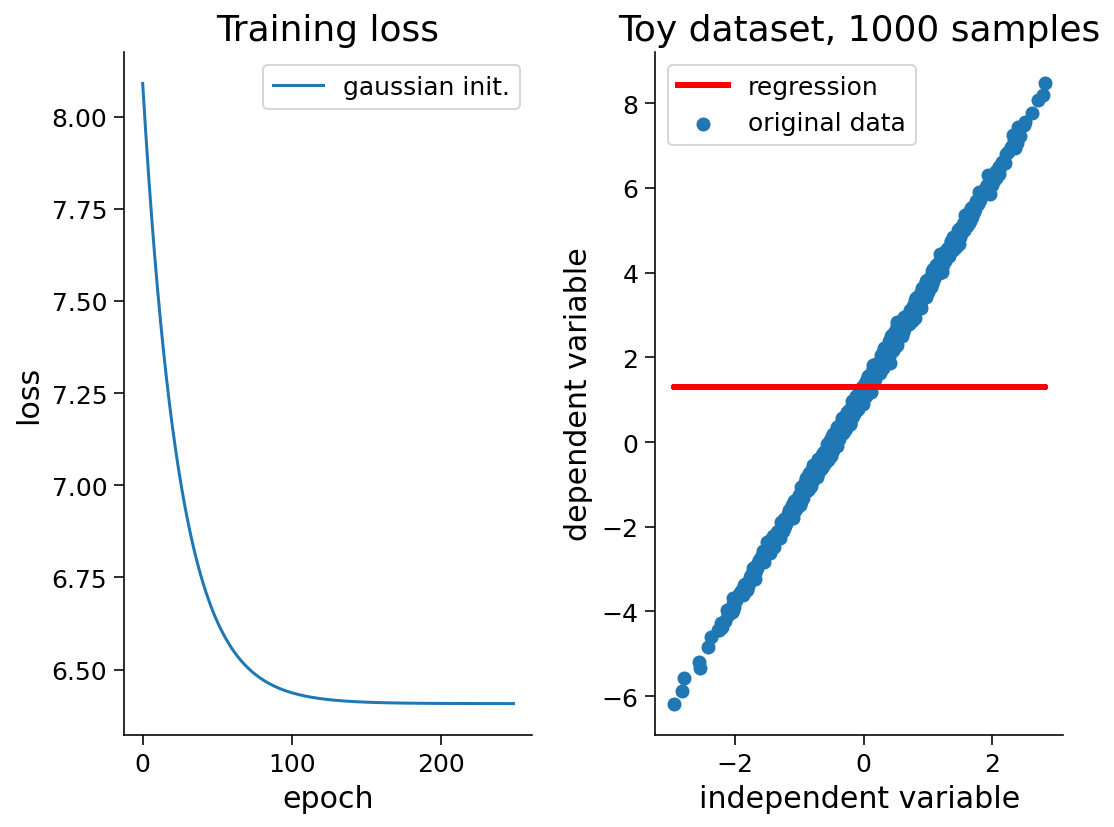

In [ ]:
# Create a deep network
net = deepNetwork(deep=True)
output = training_loop(X, y, model=net)
plotRegression(X, y, output[0], output[1])

It seems that our Deep NN fails to learn a very simple task...

---
# Section 4: The need for clever network initialization
# How to do it right. Scaling with width

Affects learning speed, convergence, generalization
- Initialize around zero
- Sample from a gaussian distribution with standard deviation $\sigma$.
- In perceptron, we initialized the weights to zero. Can we do it with neural networks?

Video available at https://youtube.com/watch?v=gEH7hHkPn8Y


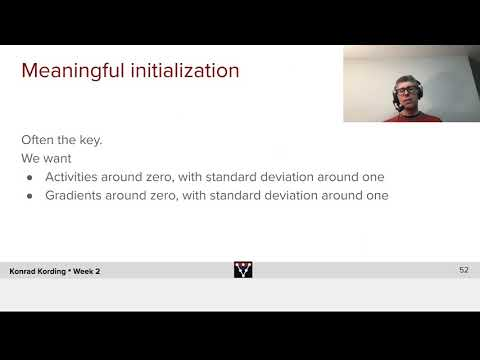

In [ ]:
#@title Video: Xavier Initialization
video = YouTubeVideo(id="gEH7hHkPn8Y", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

try: t3;
except NameError: t3=time.time()

video

## Exercise 5: Debugg the vanishing gradients problem. Scale with width

Let's run our network with initial weights close to zero, but so close!. Notice that the code is exactly the same. Scale the weights according to the width of each layer.

In [ ]:
# Initialize networks well. See what that does to initial activities and gradients
# Play with the parameters.
def deepNetwork(deep=False):
  # Network parameters
  input_dim = 1
  output_dim = 1

  if deep:
    h1, h2, h3, h4, h5, h6 = 20, 15, 10, 5, 4, 2
    # define our network
    net = nn.Sequential(nn.Linear(input_dim, h1),
                        nn.Linear(h1, h2),
                        nn.Linear(h2, h3),
                        nn.Linear(h3, h4),
                        nn.Linear(h4, h5),
                        nn.Linear(h5, h6),
                        nn.Linear(h6, output_dim))
  else:
    # define our network
    net = nn.Sequential(nn.Linear(input_dim, 1))

  # parameters initialization
  for i in range(len(net)):
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Scale weights w.r.t width!")
    ####################################################################
    n_in = ... # number of nodes in layer i
    net[i].weight.data.normal_(0, ...)
    net[i].weight.data.normal_(0, sigma)
    net[i].bias.data.fill_(0)

  return (net)


## uncomment the lines below to test your initialization choice
# net = deepNetwork(deep=True)
# predictions = training_loop(X, y, model=net)
# plotRegression(X, y, predictions, losses)


The loss after training is: 0.00973882433027029


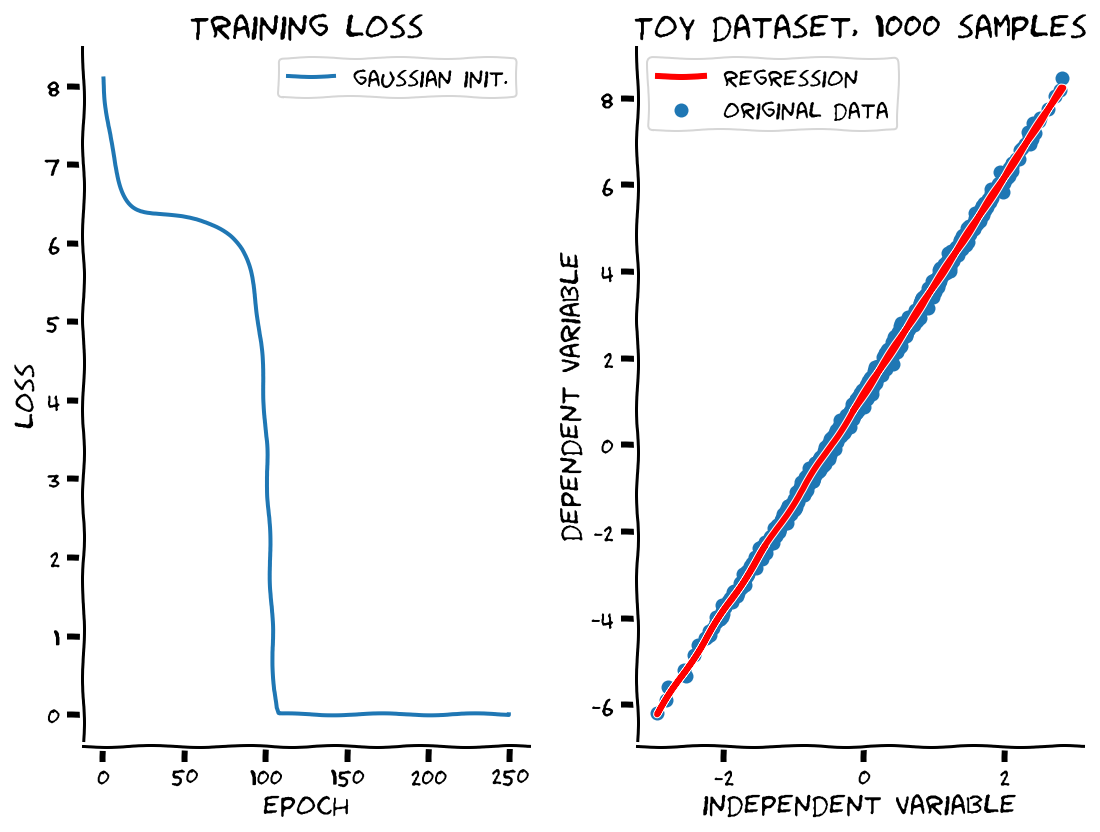

In [ ]:
# to_remove solution

# Initialize networks well. See what that does to initial activities and gradients
# Play with the parameters.
def deepNetwork(deep=False):
  # Network parameters
  input_dim = 1
  output_dim = 1

  if deep:
    h1, h2, h3, h4, h5, h6 = 20, 15, 10, 5, 4, 2
    # define our network
    net = nn.Sequential(nn.Linear(input_dim, h1),
                        nn.Linear(h1, h2),
                        nn.Linear(h2, h3),
                        nn.Linear(h3, h4),
                        nn.Linear(h4, h5),
                        nn.Linear(h5, h6),
                        nn.Linear(h6, output_dim))
  else:
    # define our network
    net = nn.Sequential(nn.Linear(input_dim, 1))

  # parameters initialization
  for i in range(len(net)):
    n_in = net[i].weight.shape[0]  # number of nodes in layer i
    net[i].weight.data.normal_(0, 1/n_in)
    net[i].bias.data.fill_(0)

  return (net)


net = deepNetwork(deep=True)
output = training_loop(X, y, model=net)
with plt.xkcd():
  plotRegression(X, y, output[0], output[1])

## Section 4.1: Xavier Initialization
Let us look at the scale distribution of an output (e.g., a hidden variable)  $o_i$  for some fully-connected layer. With  $n_in$  inputs  $x_j$  and their associated weights  $w_{ij}$  for this layer, an output is given by

\begin{equation}
o_i = \sum_{j=1}^{n_{in}} w_{ij}x_{j}
\end{equation}

The weights are drawn independently from the same distribution, which is not necessarily a Gaussian. Let us assume that this distribution has zero mean and standard deviation $\sigma_{w}^{2}$. For now, let us assume that the inputs to the layer $x_j$  also have zero mean and variance $\sigma_{x}^{2}$ and that they are independent of $w_{ij}$ and independent of one another other. With this assumptions, we can compute the mean and variance of $o_i$ as follows, taking advantage from the independence:

\begin{align}
\mathbb{E}[o_i] &{} \stackrel{def} =  \sum_{j=1}^{n_{in}}\mathbb{E}[w_{ij}x_{j}] \\
&{} = \sum_{j=1}^{n_{in}}\mathbb{E}[w_{ij}]\mathbb{E}[x_{j}] \\
&{} = 0
\end{align}

\begin{align}
Var[o_i] & {} \stackrel{def} = \mathbb{E}[o_i^{2}] - \left( \mathbb{E}[o_i] \right)^{2} \\
& {} = \sum_{j=1}^{n_{in}} \mathbb{E}[w_{ij}^{2}x_{j}^{2}] - 0 \\
&{} =  \sum_{j=1}^{n_{in}} \mathbb{E}[w_{ij}^{2}]\mathbb{E}[x_{j}^{2}] \\
&{} = n_{in}\sigma_{w}^{2}\sigma_{x}^{2}
\end{align}

In order to keep variance constant, we have to set $n_{in}\sigma_{w}^{2}=1$. Similarly, during backpropagation we can apply the same logic, albeit with gradient being propagated from the output layer with size $n_{out}$. Thus, to end with constant variance $n_{out}\sigma_{w}^{2}=1$. These two constraint cannot be satisfied simultaneously, however we can take the following constraint that combine both:

\begin{equation}
\frac{1}{2}(n_{in} + n_{out})\sigma_w^{2} = 1 \implies \sigma_w = \sqrt{\frac{1}{n_{in} + n_{out}}}
\end{equation}

Typically, the Xavier initialization samples weights from a Gaussian distribution with zero mean and standard deviation $\sigma = \sqrt{\frac{1}{n_{in} + n_{out}}}$. We can also adapt Xavier’s intuition to choose the variance when sampling weights from a uniform distribution. Note that a uniform distribution in the range $\left( -\alpha, \alpha\right)$ has variance $\sigma^2 = \alpha^2/3$, thus we initialize the weights sampling from a uniform distribution $U\left(- \sqrt{\frac{6}{n_{in} + n_{out}}}, \sqrt{\frac{6}{n_{in} + n_{out}}}\right)$.


### Exercise 6: Implement Xavier's initialization

In [ ]:
# Initialize networks well. See what that does to initial activities and gradients
# Play with the parameters.

def deepNetwork(deep=False):
  # Network parameters
  input_dim = 1
  output_dim = 1

  if deep:
    h1, h2, h3, h4, h5, h6 = 20, 15, 10, 5, 4, 2
    # define our network
    net = nn.Sequential(nn.Linear(input_dim, h1),
                        nn.Linear(h1, h2),
                        nn.Linear(h2, h3),
                        nn.Linear(h3, h4),
                        nn.Linear(h4, h5),
                        nn.Linear(h5, h6),
                        nn.Linear(h6, output_dim))
  else:
    # define our network
    net = nn.Sequential(nn.Linear(input_dim, 1))

  # parameters initialization
  for i in range(len(net)):
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Scale with Xavier's method!")
    ####################################################################    
    n_in = ...
    n_out = ...
    sigma = ...
    net[i].weight.data.normal_(0, sigma)
    net[i].bias.data.normal_(0, sigma)

  return (net)


## uncomment the lines below to test your initialization (Xavier) method
# net = deepNetwork(deep=True)
# predictions = training_loop(X, y, model=net)
# plotRegression(X, y, preds, losses, losses_xavier)


The loss after training is: 0.009738823398947716


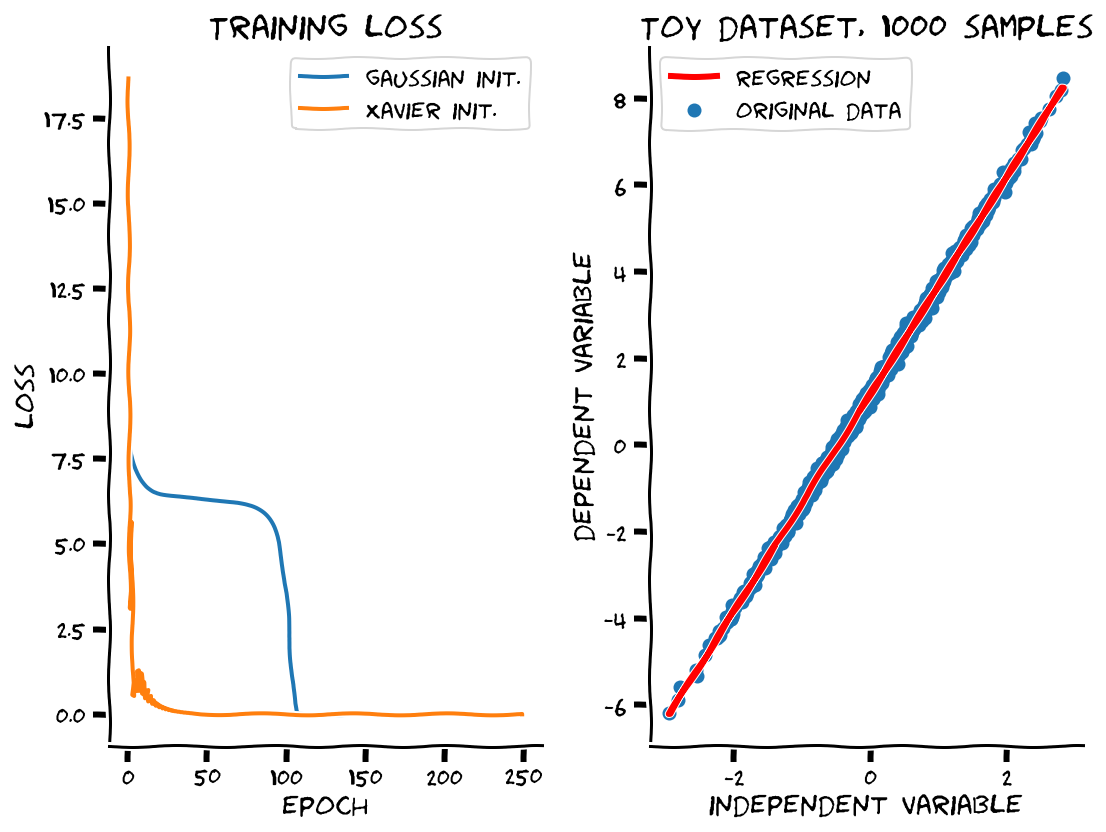

In [ ]:
# to_remove solution

def deepNetwork(deep=False):
  # Network parameters
  input_dim = 1
  output_dim = 1

  if deep:
    h1, h2, h3, h4, h5, h6 = 20, 15, 10, 5, 4, 2
    # define our network
    net = nn.Sequential(nn.Linear(input_dim, h1),
                        nn.Linear(h1, h2),
                        nn.Linear(h2, h3),
                        nn.Linear(h3, h4),
                        nn.Linear(h4, h5),
                        nn.Linear(h5, h6),
                        nn.Linear(h6, output_dim))
  else:
    # define our network
    net = nn.Sequential(nn.Linear(input_dim, 1))

  # parameters initialization
  for i in range(len(net)):
    n_in = net[i].weight.shape[0]
    n_out = net[i].weight.shape[0]
    sigma = np.sqrt(2/(n_in+n_out))
    net[i].weight.data.normal_(0, sigma)
    net[i].bias.data.normal_(0, sigma)

  return (net)


net = deepNetwork(deep=True)
outputXav = training_loop(X, y, model=net)
with plt.xkcd():
  plotRegression(X, y, outputXav[0], output[1], outputXav[1])

Although both methods converge in the same set of parameters, Xavier's initialization method converges faster. This feature is very important in large scale applications, where the demand for speed is high.

Video available at https://youtube.com/watch?v=XFHbvGXP1Ng


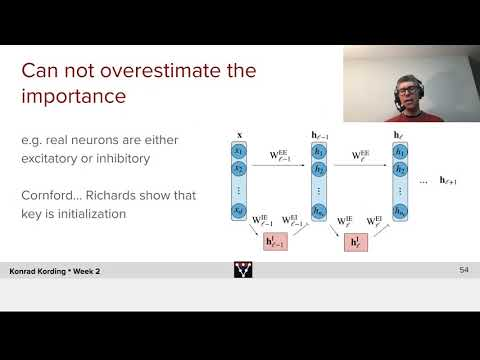

In [ ]:
#@title Video: Xavier vs Simpler Initialization
import time
try: t4;
except NameError: t4=time.time()

video = YouTubeVideo(id="XFHbvGXP1Ng", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

---
# Section 5: Race ideas (first components increase exponentially)

Video available at https://youtube.com/watch?v=c3VNOmbi1tU


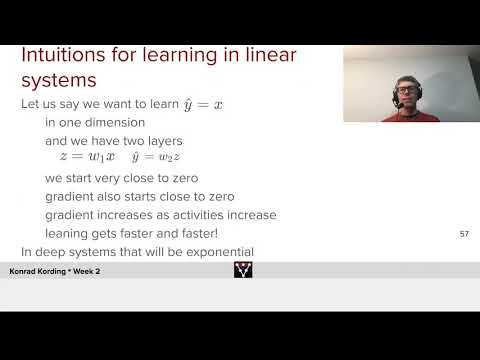

In [ ]:
#@title Video: Accelerating Growth
import time
try: t5;
except NameError: t5=time.time()

video = YouTubeVideo(id="c3VNOmbi1tU", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## 1D scenario

So, lets take the simplest case, where we have a linear network with multiple layers but only one neuron (i.e., node) per layer. We are going to plot the weights against epochs.

In [ ]:
# 1D data
original_w = torch.tensor([2.5]).reshape(-1,1)
original_b = 1.2
N = 1000  # number of examples
inputs, targets = synthetic_dataset(original_w, original_b,
                                    num_examples=1000,
                                    sigma=0.1,
                                    seed=2021)
inputs = inputs.T
print(inputs.shape, targets.shape)

torch.Size([1000, 1]) torch.Size([1000, 1])


In [ ]:
# Define the model
def model(x, params):
  w1, b1, w2, b2, w3, b3 = params[0], params[1], params[2], params[3], params[4], params[5]

  h1 = x @ w1.t()+ b1
  h2 = h1 @ w2.t()+ b2
  out = h2 @ w3.t() + b3
  return out

# MSE loss
def mse(t1, t2):
  diff = t1 - t2
  return torch.sum(diff * diff) / diff.numel()

In [ ]:
def training_modes(inputs, targets):

  input_dim = inputs.shape[1]
  output_dim = targets.shape[1]
  hidden = 20

  # Initial Weights and biases
  sigma = 0.001
  w1 = Variable(torch.mul(torch.randn(hidden, input_dim), sigma),
                requires_grad=True)
  b1 = Variable(torch.mul(torch.randn(hidden), 0.0),
                requires_grad=True)

  w2 = Variable(torch.mul(torch.randn(output_dim, hidden), sigma),
                requires_grad=True)
  b2 = Variable(torch.mul(torch.randn(output_dim), 0.0),
                requires_grad=True)

  params = [w1, b1, w2, b2]

  lr  = 2e-3  # learning rate
  num_epochs = 1000

  # Train for num_epochs
  losses = []
  rank = 5
  modes = np.empty((rank, num_epochs))

  # this few lines would implement a progress bar and loss description
  epoch_range = trange(num_epochs, desc='loss: ', leave=True)
  for epoch in epoch_range:
    if losses:
      epoch_range.set_description("loss: {:.6f}".format(losses[-1]))
      epoch_range.refresh() # to show immediately the update
    time.sleep(0.01)

    preds = modelSVD(inputs, params)
    
    loss = mse(preds, targets)
    loss.backward()

    # SVD applied on the matrix product
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Calculate w1.T*w2.T and the apply SVD")
    #################################################################### 
    w_mult = ...
    w_svd = ...
    modes[:,epoch] = w_svd[:rank]
    # Adjust weights & reset gradients
    with torch.no_grad():
      # Gradient descent
      w1 -= w1.grad * lr
      b1 -= b1.grad * lr
      w2 -= w2.grad * lr
      b2 -= b2.grad * lr
      # flush fradients
      w1.grad.zero_()
      b1.grad.zero_()
      w2.grad.zero_()
      b2.grad.zero_()
        
    losses.append(loss)

  return (losses, modes, num_epochs)


## uncomment the lines below to test your SVD method
# output = training_modes(inputs, targets)
# plot_learning_modes(output[0], output[2], output[1], rank=5)

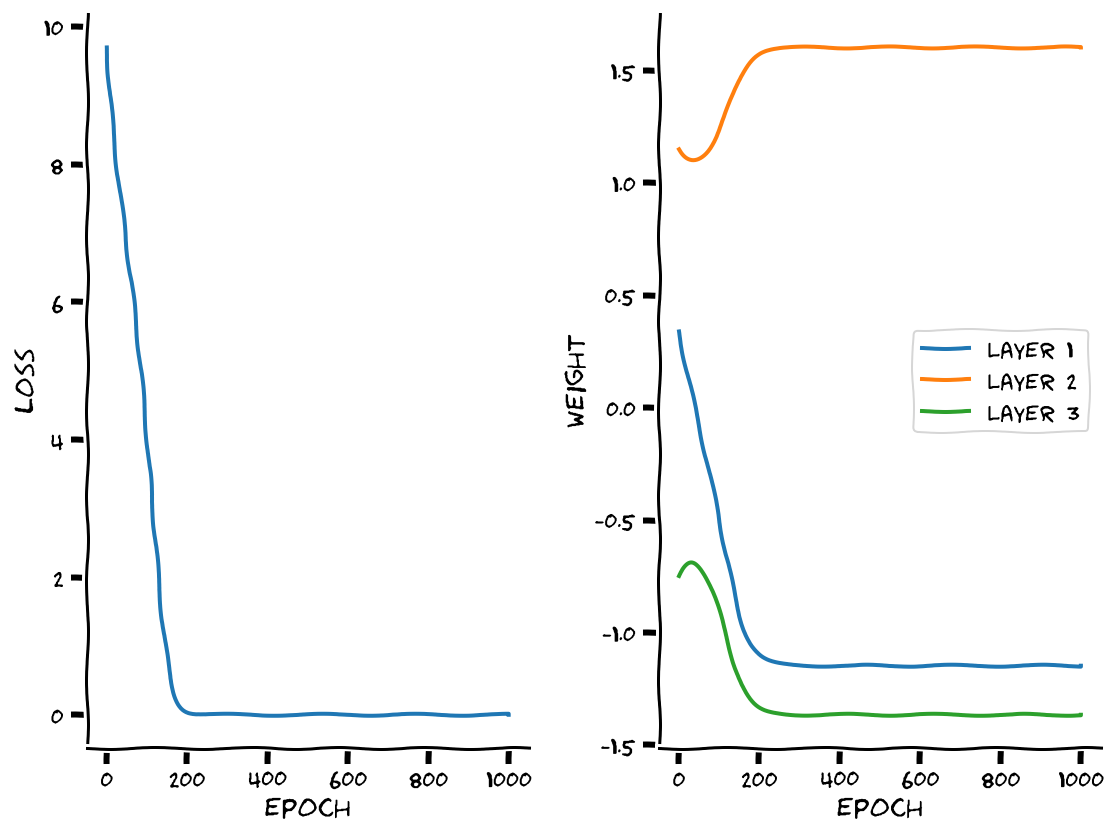

In [ ]:
# to_remove solution
def training_1d(inputs, targets):

  input_dim = inputs.shape[1]
  output_dim = targets.shape[1]
  hidden = 1

  # Initial Weights and biases
  sigma = 1.
  w1 = Variable(torch.mul(torch.randn(hidden, input_dim), sigma),
                requires_grad=True)
  b1 = Variable(torch.mul(torch.randn(hidden), 0.0),
                requires_grad=True)

  w2 = Variable(torch.mul(torch.randn(hidden, hidden), sigma),
                requires_grad=True)
  b2 = Variable(torch.mul(torch.randn(hidden), 0.0),
                requires_grad=True)
  
  w3 = Variable(torch.mul(torch.randn(output_dim, hidden), sigma),
                requires_grad=True)
  b3 = Variable(torch.mul(torch.randn(output_dim), 0.0),
                requires_grad=True)

  params = [w1, b1, w2, b2, w3, b3]

  lr  = 2e-3  # learning rate
  num_epochs = 1000

  # Train for num_epochs
  losses = []
  weights = np.empty((len(params) // 2, num_epochs))

  # this few lines would implement a progress bar and loss description
  epoch_range = trange(num_epochs, desc='loss: ', leave=True)
  for epoch in epoch_range:
    if losses:
      epoch_range.set_description("loss: {:.6f}".format(losses[-1]))
      epoch_range.refresh() # to show immediately the update
    time.sleep(0.01)

    preds = model(inputs, params)
    
    loss = mse(preds, targets)
    loss.backward()

    # We store the weights
    weights[:, epoch] = [w1.detach().numpy(),
                        w2.detach().numpy(),
                        w3.detach().numpy()]
    
    # Adjust weights & reset gradients
    with torch.no_grad():
      # Gradient descent
      w1 -= w1.grad * lr
      b1 -= b1.grad * lr
      w2 -= w2.grad * lr
      b2 -= b2.grad * lr
      w3 -= w3.grad * lr
      b3 -= b3.grad * lr
      # flush fradients
      w1.grad.zero_()
      b1.grad.zero_()
      w2.grad.zero_()
      b2.grad.zero_()
      w3.grad.zero_()
      b3.grad.zero_()
        
    losses.append(loss.item())

  return (losses, weights, num_epochs)


output = training_1d(inputs, targets)
losses = output[0]
weights = output[1]

with plt.xkcd():
  plot_weight(losses, weights)

## Multiple Dimensions

Video available at https://youtube.com/watch?v=MrqLuBsVtWU


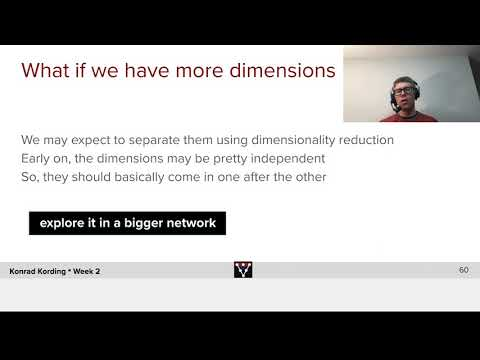

In [ ]:
#@title Video: How Multiple Dimensions Kick In
import time
try: t6;
except NameError: t6=time.time()

video = YouTubeVideo(id="MrqLuBsVtWU", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

Here, we go deeper into understanding the learning dynamics. As we have shown in the previous examples, a linear neural network can learn a set of parameters in order to perform linear regression.

The idea behind this approach is to find an input-output relationship of a linear neural network. Thus, we want to take into account the weight matrix product, i.e., $W_{[1]}^{\text{T}}W_{[2]}^{\text{T}} \dots W_{[L]}^{\text{T}}$, where $L$ denotes the number of layers in our network.

Towards understandind the learning dynamics, we decompose the weight matrix product into orthogonal vectors and then to keep track of the singular values across time evolution, i.e., epochs. 

From Linear Algebra, we know that we can decompose any matrix $A$ into two orthogonal matrices and one diagonal matrix with the relationship:

\begin{equation}
A = UΣV^{\text{T}}
\end{equation}

Here, we perform the so-called singular value decomposition (SVD) in the weight matrix product at every epoch. We store the first $k$ singular values and then we plot them against epochs.

The intuition behind this approach is that we want to know how much a column of the weight product matrix is learned over time. That is, what is the size of the learned $W_{[1]}^{\text{T}}W_{[2]}^{\text{T}}$ projected onto that column, i.e., the corresponding singular value.

To better illustarte this idea, we will use syntetic data in high dimensions. Here, our independent variables, $x$ are in the $100D$ space, whereas the dependent ones $y$, are in $10D$ space.

If the dependent variable lies in the 2D space and above, the method is also colled **multivariate linear regression**.

Notice that our data $\textbf{X} \in \mathbb{R}^{NxD}$, where $N$ is the number of examples, and $D$ the number of features.

### Exercise 7: Compute the learning modes via SVD

Here, you have to apply the Singular Value Decomposition method to the weight product matrix. 

In [ ]:
# More dimensions; Start with some random original weights.
# Go to multiple dimensions
original_w = torch.randn((100, 10))
original_b = 1.2
N = 1000  # number of examples
X, y = synthetic_dataset(original_w, original_b,
                         num_examples=N,
                         sigma=0.1,
                         seed=2021)

# We take the transpose matrices
inputs = X.T
targets = y.T

print(inputs.shape, targets.shape)

torch.Size([1000, 100]) torch.Size([1000, 10])


In [ ]:
# Define the model
def modelSVD(x, params):
  w1, b1, w2, b2 = params[0], params[1], params[2], params[3]

  h1 = x @ w1.t()+ b1
  out = h1 @ w2.t() + b2
  return out

# MSE loss
def mse(t1, t2):
  diff = t1 - t2
  return torch.sum(diff * diff) / diff.numel()

In [ ]:
def training_modes(inputs, targets):

  input_dim = inputs.shape[1]
  output_dim = targets.shape[1]
  hidden = 20

  # Initial Weights and biases
  sigma = 0.01
  w1 = Variable(torch.mul(torch.randn(hidden, input_dim), sigma),
                requires_grad=True)
  b1 = Variable(torch.mul(torch.randn(hidden), 0.0),
                requires_grad=True)

  w2 = Variable(torch.mul(torch.randn(output_dim, hidden), sigma),
                requires_grad=True)
  b2 = Variable(torch.mul(torch.randn(output_dim), 0.0),
                requires_grad=True)

  params = [w1, b1, w2, b2]

  lr  = 2e-3  # learning rate
  num_epochs = 2000

  # Train for num_epochs
  losses = []
  rank = 5
  modes = np.empty((rank, num_epochs))

  # this few lines would implement a progress bar and loss description
  epoch_range = trange(num_epochs, desc='loss: ', leave=True)
  for epoch in epoch_range:
    if losses:
      epoch_range.set_description("loss: {:.6f}".format(losses[-1]))
      epoch_range.refresh() # to show immediately the update
    time.sleep(0.01)

    preds = modelSVD(inputs, params)
    
    loss = mse(preds, targets)
    loss.backward()

    # SVD applied on the matrix product
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Calculate w1.T*w2.T and the apply SVD")
    #################################################################### 
    w_mult = ...
    w_svd = ...
    modes[:,epoch] = w_svd[:rank]
    # Adjust weights & reset gradients
    with torch.no_grad():
      # Gradient descent
      w1 -= w1.grad * lr
      b1 -= b1.grad * lr
      w2 -= w2.grad * lr
      b2 -= b2.grad * lr
      # flush fradients
      w1.grad.zero_()
      b1.grad.zero_()
      w2.grad.zero_()
      b2.grad.zero_()
        
    losses.append(loss)

  return (losses, modes, num_epochs)


## uncomment the lines below to test your SVD method
# output = training_modes(inputs, targets)
# plot_learning_modes(output[0], output[2], output[1], rank=5)

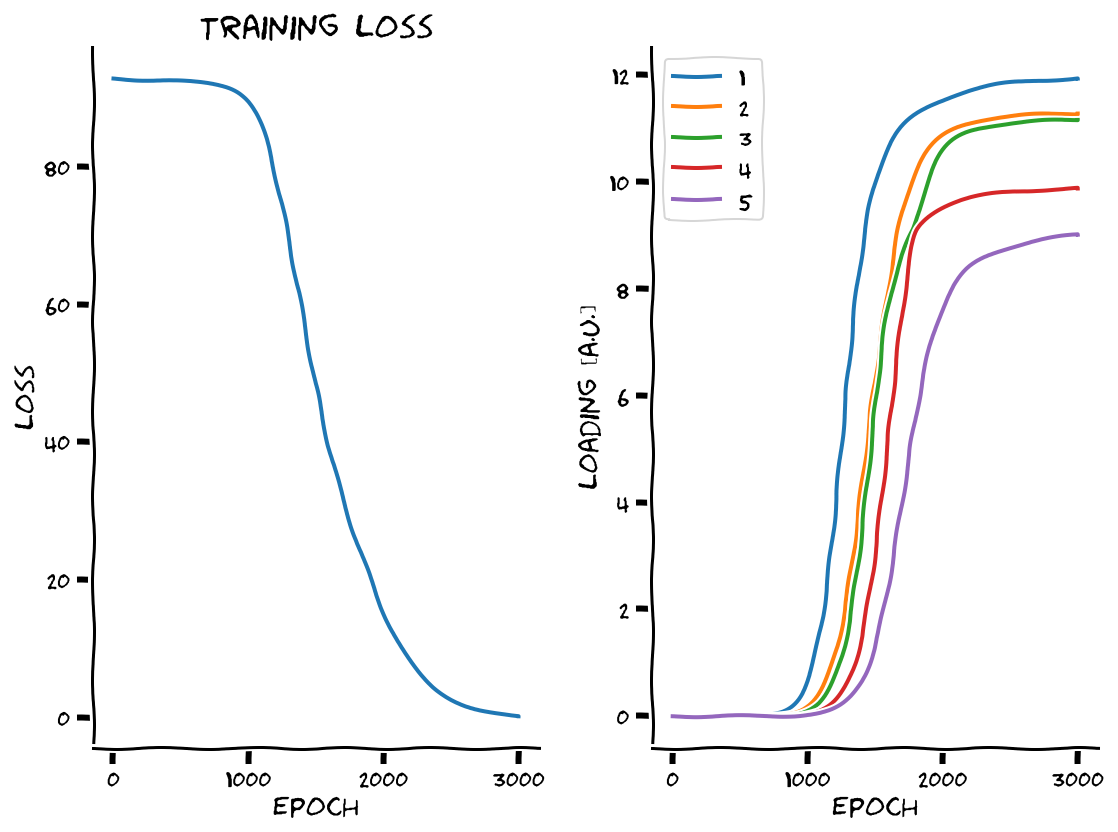

In [ ]:
# to_remove solution

def training_modes(inputs, targets):

  input_dim = inputs.shape[1]
  output_dim = targets.shape[1]
  hidden = 20

  # Initial Weights and biases
  sigma = 0.001
  w1 = Variable(torch.mul(torch.randn(hidden, input_dim), sigma),
                requires_grad=True)
  b1 = Variable(torch.mul(torch.randn(hidden), 0.0),
                requires_grad=True)

  w2 = Variable(torch.mul(torch.randn(output_dim, hidden), sigma),
                requires_grad=True)
  b2 = Variable(torch.mul(torch.randn(output_dim), 0.0),
                requires_grad=True)

  params = [w1, b1, w2, b2]

  lr  = 2e-3  # learning rate
  num_epochs = 3000

  # Train for num_epochs
  losses = []
  rank = 5
  modes = np.empty((rank, num_epochs))

  # this few lines would implement a progress bar and loss description
  epoch_range = trange(num_epochs, desc='loss: ', leave=True)
  for epoch in epoch_range:
    if losses:
      epoch_range.set_description("loss: {:.6f}".format(losses[-1]))
      epoch_range.refresh() # to show immediately the update
    time.sleep(0.01)

    preds = modelSVD(inputs, params)
    
    loss = mse(preds, targets)
    loss.backward()

    # SVD applied on the matrix product
    w_mult = (w1.T @ w2.T).detach().numpy()
    w_svd = np.linalg.svd(w_mult, compute_uv=False, full_matrices=True)
    modes[:,epoch] = w_svd[:rank]
    # Adjust weights & reset gradients
    with torch.no_grad():
      # Gradient descent
      w1 -= w1.grad * lr
      b1 -= b1.grad * lr
      w2 -= w2.grad * lr
      b2 -= b2.grad * lr
      # flush fradients
      w1.grad.zero_()
      b1.grad.zero_()
      w2.grad.zero_()
      b2.grad.zero_()
        
    losses.append(loss.detach().numpy())

  return (losses, modes, num_epochs)


output = training_modes(inputs, targets)
with plt.xkcd():
  plot_learning_modes(output[0], output[2], output[1], rank=5)

As we see from the loss plot, initially our networks learns very slow, and then the first learning component exponentially increases, which means fast learning. After a phase where the learning curve is almost constant with respect to epochs, the rest of the components increase exponentially, which explains the convergence of our model. Of course, we can use more complex approaches to retrieve the learning components (e.g., using `tensorly` or `tensortools`). These tools perform tensor decompositions (a similar to SVD approach for $3D$ tensors).

In [ ]:
#@markdown what will happen if we increase the learning rate?
learning_modes = '' #@param {type:"string"}

---
# Section 6: Cost functions - how problems give rise to cost functions



Video available at https://youtube.com/watch?v=O8psSHspno0


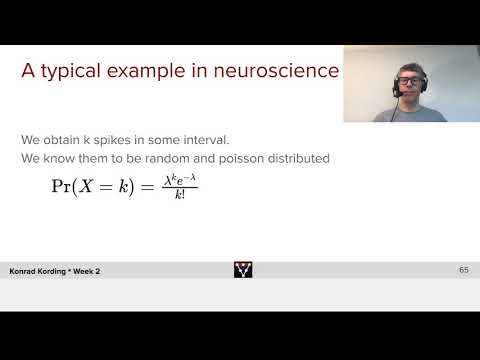

In [ ]:
#@title Video: LogP as a Cost Function
import time
try: t7;
except NameError: t7=time.time()

video = YouTubeVideo(id="O8psSHspno0", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## Section 6.1: MSE, where is MSE good? Statistical properties of MSE estimators.

As we already defined previously, in linear regression models a common cost function is the so-called **Mean Squared Error (MSE)**. This cost function is also known as *Quadratic Loss*, as the function is of quadratic form, and *L2 Loss*, because the squared errors are of the same form as the L2 norm of a vector. As a quadratic function, the range of MSE is from $0$ to $\infty$.

Here, we more formally motivate the MSE cost function using assumptions about the distribution of additive noise in our dataset. As we show in the previous tutorial, the MSE in a dataset $\textbf{X}$ is given by:

\begin{align}
L(\mathbf{w}, b) &{} = \frac{1}{N}  \sum_{i=1}^{N} \left( \hat{y}^{[i]} - y^{[i]}\right)^2 \\
&{}= \frac{1}{N} \sum_{i=1}^{N} \left(\mathbf{w}^{\text{T}} \mathbf{x}^{[i]} + b - y^{[i]}\right)^{2}.
\end{align}

One way to motivate linear regression with the mean squared error loss function, i.e., $L(\mathbf{w}, b)$, is to formally assume that observations arise from noisy observations, where the noise is normally distributed (see W2 Part 1):

\begin{equation}
y = \textbf{w}^T\textbf{x} + b + \epsilon, \epsilon \sim \mathcal{N}(\mu=0, \sigma)
\end{equation}

Therefore, we can write the *likelihood* of seeing a particular example $y$ given the independent variable $\mathbf{x}$

\begin{equation}
p(y|\mathbf{x}) = \frac{1}{2\pi\sigma^2} \text{exp}\left( -\frac{1}{2\sigma^2} \left( \mathbf{w}^T\mathbf{x} + b - y \right)^2 \right)
\end{equation}

Assuming that all values in our dataset are independent and identically distributed (i.i.d.), the total likelihood of our dtaset is given by:

\begin{equation}
P(\mathbf{y}|\mathbf{X}) = \prod_{n=1}^N p\left(y^{[i]}|\mathbf{x}^{[i]} \right)
\end{equation}

According to the principle of maximum likelihood, the best values of parameters  $\mathbf{w}$  and  $b$  are those that maximize the likelihood of the entire dataset (i.e., *maximum likelihood estimators*).

While, maximizing the product of many exponential functions, might look difficult, we can simplify things significantly, without changing the objective, by maximizing the log of the likelihood instead. For historical reasons, optimizations are more often expressed as minimization rather than maximization. So, without changing anything we can minimize the negative log-likelihood


\begin{equation}
-\text{log} P(\mathbf{y}|\mathbf{X}) = -\text{log} \left( \prod_{n=1}^N p\left(y^{[i]}|\mathbf{x}^{[i]} \right) \right)
\end{equation}

Using the logarithm property states that the logarithm of a product is the sum of the logarithms of the individual components being multiplied, i.e., $\text{log}(a \cdot b) = \text{log}(a) + \text{log}(b)$, thus the log-likelihood is given by:

\begin{align}
-\text{log} P(\mathbf{y}|\mathbf{X}) &{}= -\text{log} \left( \prod_{n=1}^N p\left(y^{[i]}|\mathbf{x}^{[i]} \right) \right) \\
&{}= -\sum_{n=1}^N \text{log}\left( p\left(y^{[i]}|\mathbf{x}^{[i]} \right) \right) \\
&{} = \sum_{i=2}^N \left( \frac{1}{2}\text{log}(2\pi\sigma^2) + \frac{1}{2\sigma^2} \left( \mathbf{w}^T\mathbf{x}^{[i]} + b - y^{[i]} \right)^2 \right).
\end{align}

Assuming that $\sigma$ is constant for all examples, the minimization of the negative *log-likelihood* with respect to the parameters $\textbf{w}$ and $b$ can be reduced by removing the left order of the summation, and the remaining order is the squared loss (taking out the constant $\frac{1}{2\sigma^2}$. In other words, minimizing the **mean squared error** is equivalent to **maximum likelihood estimation** of a linear model under the assumption of additive Gaussian noise with constant variance ($\sigma^2$).




### Section 6.1.1 Download and Visualize the dataset

Lets now see how some sample examples are look like

dataset keys: dict_keys(['events', 'features', 'neurons_M1', 'neurons_PMd'])
events: dict_keys(['goCueTime', 'rewardTime', 'targetOnTime'])
features dict_keys(['endpointOfReach', 'reward'])
number of PMd neurons: 195


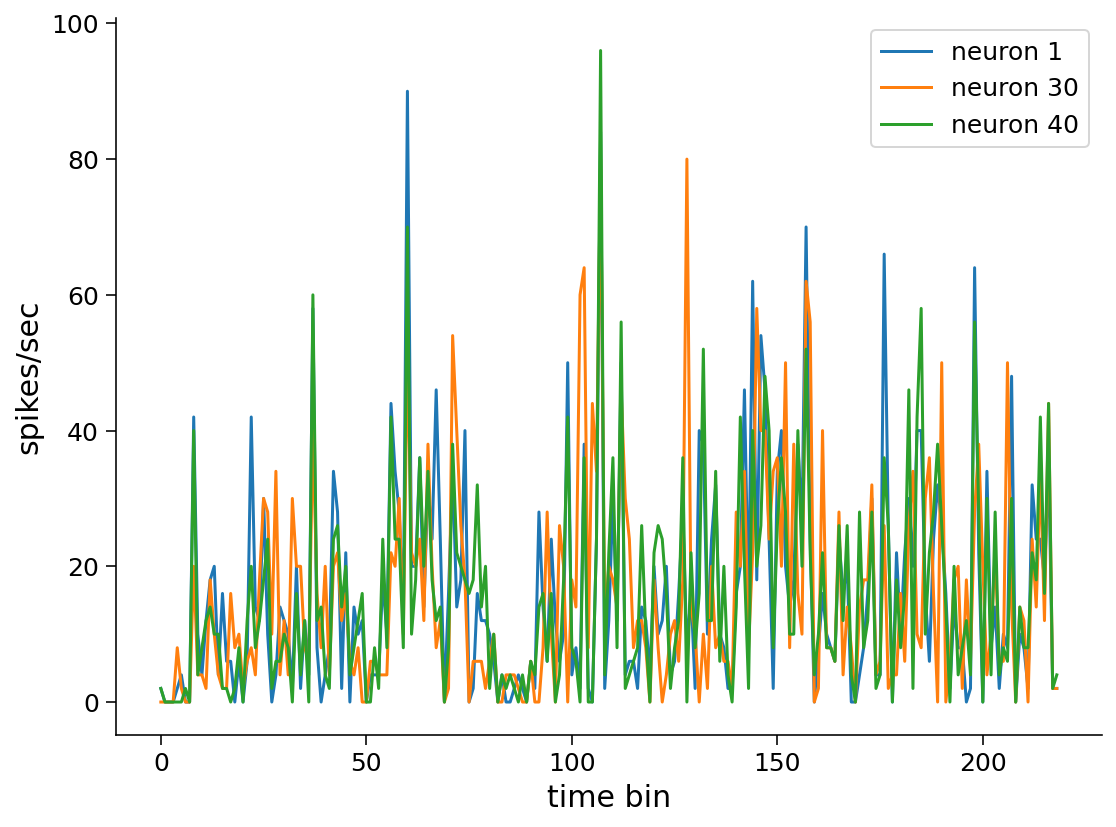

In [ ]:
DATA = getData()

x_train = DATA[0]
y_train = DATA[1]
x_test = DATA[2]
y_test = DATA[3]

neuron_id = [1, 30, 40]
plt.figure()
for id in neuron_id:
  plt.plot(x_train[id,:], label=f'neuron {id}')
plt.xlabel('time bin')
plt.ylabel('spikes/sec')
plt.legend()
plt.show()

### Section 6.1.2 Construct the model using `nn.Module`

In [ ]:
# Model
class SimpleNet(nn.Module):
  # Initialize the layers
  def __init__(self, input_dim, hidden, output_dim):
    super().__init__()
    
    self.input_dim = input_dim
    self.hidden = hidden
    self.output_dim = output_dim

    self.linear1 = nn.Linear(self.input_dim, self.hidden[0])
    
    self.linears = nn.ModuleList([nn.Linear(hidden[i-1],
                                            hidden[i]) for i in range(1, len(self.hidden))])
    
    self.linear2 = nn.Linear(self.hidden[-1], self.output_dim)
  
  # Perform the computation
  def forward(self, x):
    x = self.linear1(x)
    for i, l in enumerate(self.linears):
      x = self.linears[i](x)
    out = self.linear2(x)
    return out


model = SimpleNet(input_dim=219, hidden = [50, 25, 10], output_dim=1)
print(model)

SimpleNet(
  (linear1): Linear(in_features=219, out_features=50, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=50, out_features=25, bias=True)
    (1): Linear(in_features=25, out_features=10, bias=True)
  )
  (linear2): Linear(in_features=10, out_features=1, bias=True)
)


### Section 6.1.3 Train the model

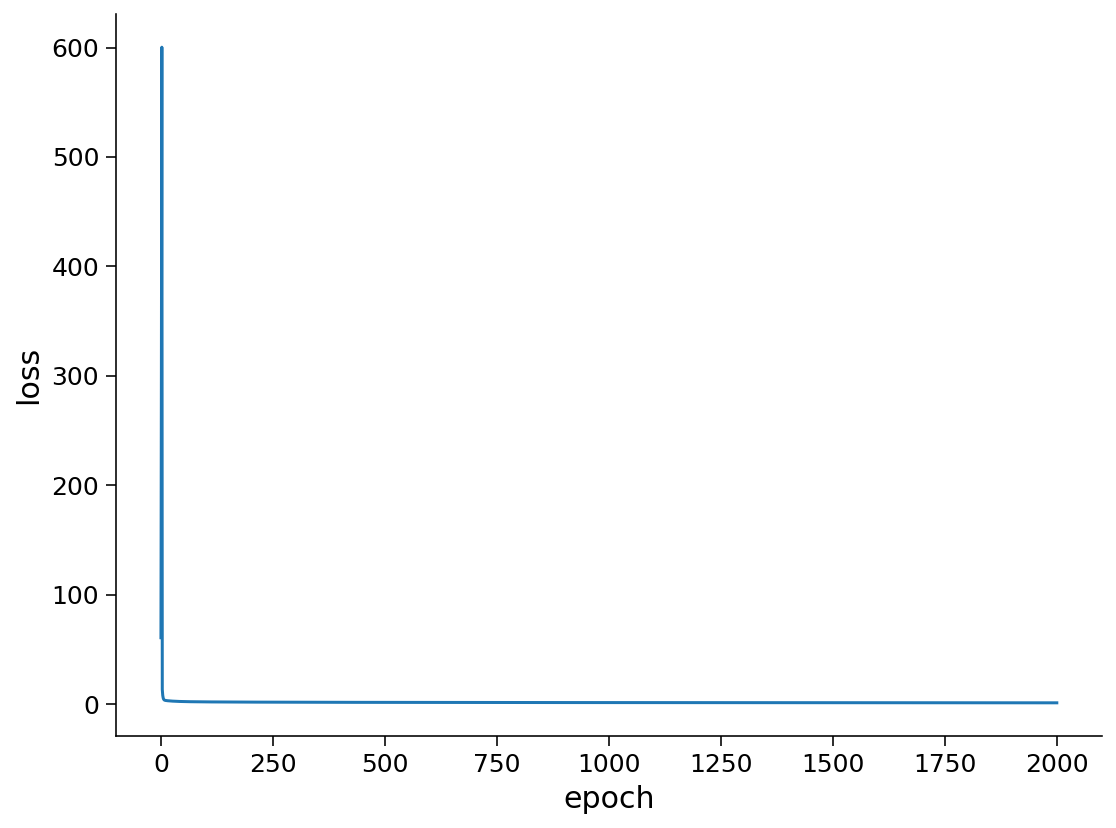

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Converting inputs and labels to Variable
if torch.cuda.is_available():
  inputs = Variable(torch.from_numpy(x_train).float().cuda())
  targets = Variable(torch.from_numpy(y_train).float().cuda())
  inputs_test = Variable(torch.from_numpy(x_test).float().cuda())
  targets_test = Variable(torch.from_numpy(y_test).float().cuda())
else:
  inputs = Variable(torch.from_numpy(x_train).float())
  targets = Variable(torch.from_numpy(y_train).float())
  inputs_test = Variable(torch.from_numpy(x_test).float())
  targets_test = Variable(torch.from_numpy(y_test).float())

# input size dimension - features
input_dim = inputs.shape[1]
output_dim = targets.shape[1]
# size of the hidden layer
hidden = [50, 10]

learningRate = 1e-4
epochs = 2000

model = SimpleNet(input_dim, hidden, output_dim)

# Make it run on GPU!
model.train(True)
model.to(device)

# Loss function
criterion = nn.MSELoss()
# Gradient Descent
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

loss_val = []

epoch_range = trange(epochs, desc='loss: ', leave=True)
for epoch in epoch_range:
  if loss_val:
    epoch_range.set_description("loss: {:.6f}".format(loss_val[-1]))
    epoch_range.refresh() # to show immediately the update
  time.sleep(0.01)

  # Clear gradient buffers because we don't want any gradient from
  # previous epoch to carry forward, dont want to cummulate gradients
  optimizer.zero_grad()        
  # get output from the model, given the inputs
  outputs = model(inputs)
  # get loss for the predicted output
  loss = criterion(outputs, targets)
  # get gradients w.r.t to parameters
  loss.backward()

  # update parameters
  optimizer.step()
  loss_val.append(loss.item())

plt.figure()
plt.plot(loss_val)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### Section 6.1.4 Test the model

Loss in the test set: 2.1214632987976074


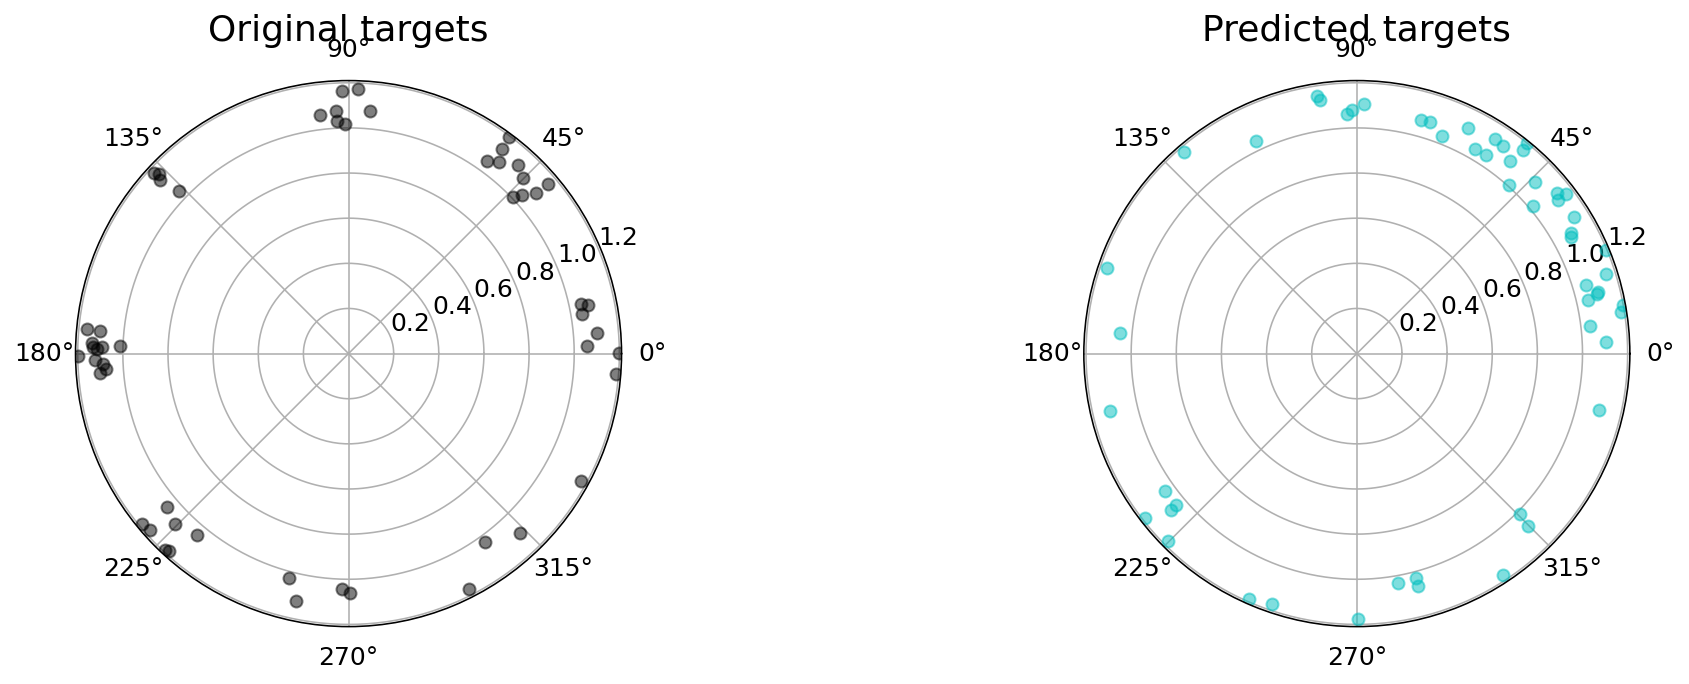

In [ ]:
# Testing the model
yhat_test = model(inputs_test)
loss_test = criterion(yhat_test, targets_test)
print(f'Loss in the test set: {loss_test}')

# Visualize decoded reach direction

plt.figure(figsize=[15, 5])
jitter = 0.2 * np.random.rand(x_test.shape[0])
plt.subplot(121, polar=True)
plt.plot(y_test, np.ones(x_test.shape[0]) + jitter, 'ko', alpha=0.5)
plt.title('Original targets')

plt.subplot(122, polar=True)
plt.plot(yhat_test.cpu().detach().numpy(),
         np.ones(yhat_test.shape[0]) + jitter,
         'co', alpha=0.5)
plt.title('Predicted targets')
plt.show()

## Section 6.2: Mean Absolute Error (MAE)

Video available at https://youtube.com/watch?v=jxp5faHAZgM


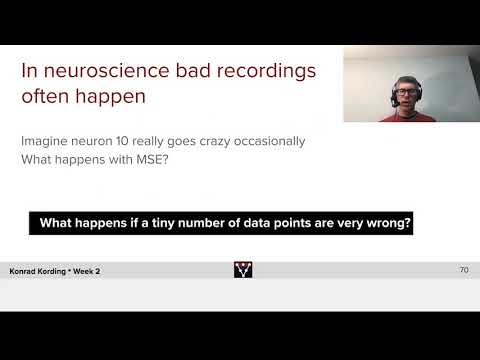

In [ ]:
#@title Video: Outliers in Neural Activities
import time
try: t8;
except NameError: t8=time.time()

video = YouTubeVideo(id="jxp5faHAZgM", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

Mean Absolute Error (MAE) is another loss function used for regression models. MAE is the sum of absolute differences between our target and predicted variables. So, it measures the average magnitude of errors in a set of predictions, without considering their directions. Similarly, the range of MAE is from $0$ to $\infty$. MAE is also referred to as *L1 Loss*.

The mathematical description of MAE is given by:

\begin{align}
L(\mathbf{w}, b) &{} = \frac{1}{N}  \sum_{i=1}^{N} \left| \hat{y}^{[i]} - y^{[i]}\right| \\
&{}= \frac{1}{N} \sum_{i=1}^{N} \left| \mathbf{w}^{\text{T}} \mathbf{x}^{[i]} + b - y^{[i]}\right|.
\end{align}

### Section 6.2.1 MSE vs. MAE (L2 Loss vs. L1 Loss)

In short, using the squared error is easier to solve, but using the absolute error is more robust to outliers. But let’s understand why!
Whenever we train a machine learning model, our goal is to find the point that minimizes loss function. Of course, both functions reach the minimum when the prediction is exactly equal to the true value.

Since MSE squares the error $l = \left( \hat{y} - y \right)^2$, the value of error ($l$) increases quickly if $l > 1$. If we have an outlier in our data, the value of $l$ will be high and $l^2$ will be $>> |l|$. This will make the model with MSE loss to weight more the outliers comparing with a model containing MAE as a loss function.

MAE loss is useful if the training data is corrupted with outliers (i.e., we erroneously receive unrealistically huge negative/positive values in our training environment, but not our testing environment).

Intuitively, we can think about it like this: If we only had to give one prediction for all the observations that try to minimize MSE, then that prediction should be the **mean** of all target values. However, if we try to minimize MAE, that prediction would be the **median** of all examples. We know that median is more robust to outliers than mean, which consequently makes MAE more robust to outliers than MSE.

One big problem in using MAE loss (especially in neural networks) is that its gradient is the same throughout, which means the gradient will be large even for small loss values. This isn’t good for learning. To fix this, we can use dynamic learning rate which decreases as we move closer to the minima (we will see this technique later in the course). MSE behaves nicely in this case and will converge even with a fixed learning rate. The gradient of MSE loss is high for larger loss values and decreases as loss approaches $0$, making it more precise at the end of training.

In the table below, we give an illustartive example using some random error values.

\begin{array}{ccc}
x^{[i]} & error & error^2 & |error| \\
\hline
x^{[1]} & 0 & 0 & 0 \\
x^{[2]} & 1 & 1 & 1 \\
x^{[3]} & .5 & .25 & .5 \\
x^{[4]} & 3 & 9 & 3 \\
x^{[5]} & -1.5 & 2.25 & 1.5  \\
x^{[6]} & 15 & 225 & 15 \\
\hline
total &  & RMSE\approx6.3 & MAE=3.5
\end{array}

where RMSE stands for Root MSE (i.e., we take the square root of the MSE to make both mean errors at the same scale!).


The total error is significantly higher when we introduce an outlier to some arbitrary datset (i.e., $ID=5$).

So far, so good. But, lets go back to our original dataset and manually add a highly unlikely value in the training dataset.

### Section 6.2.2 Corrupt the data by adding a tiny number of cells as outliers

[ 98  31  74 198  52   1  81 201 165 145 190 167  79  26 200 125 114 148
 182 184]


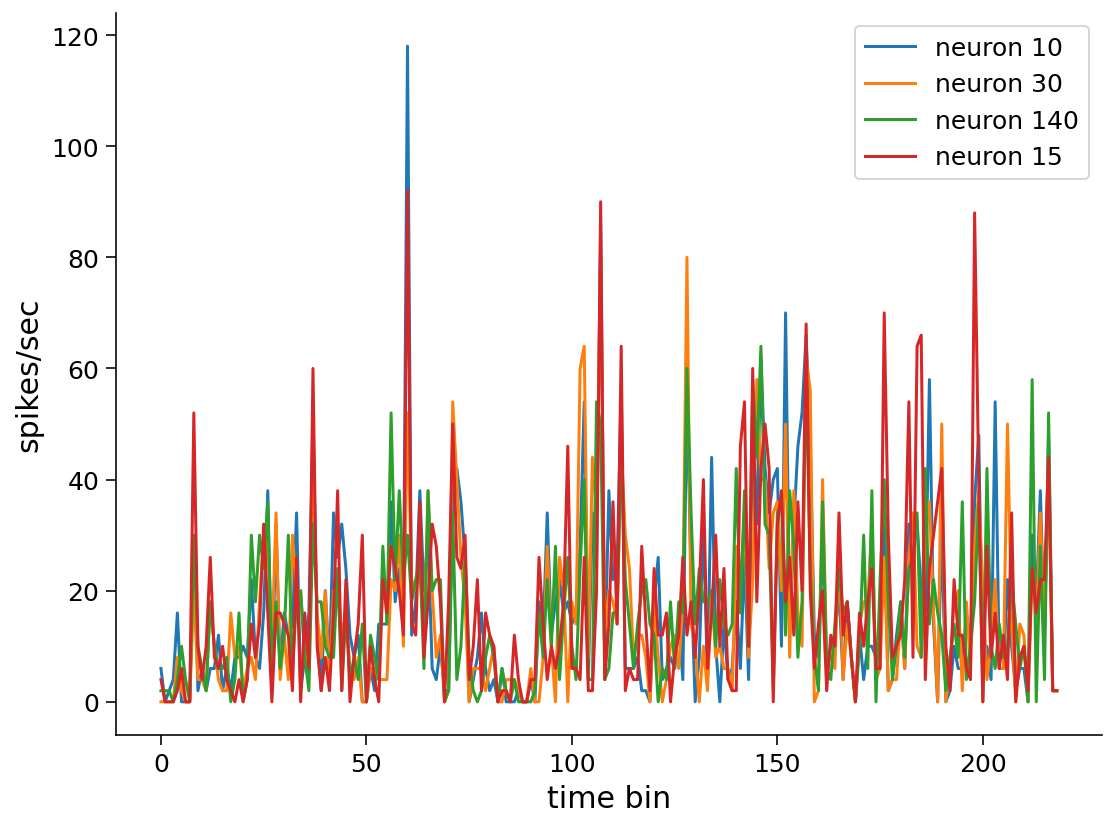

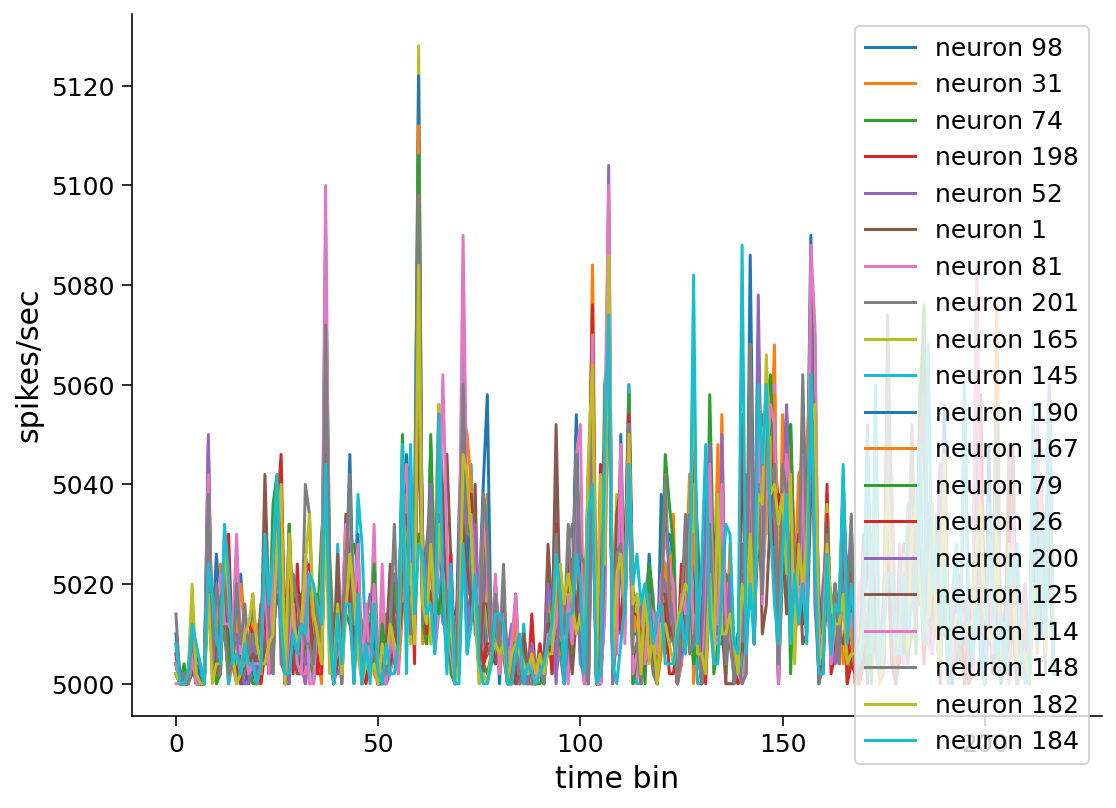

In [ ]:
# Add an outliers in the training set
inputs_new = inputs.cpu().detach().numpy()

# Choose some neurons to be the outliers!
outliers = np.random.choice(range(len(inputs)), size=20, replace=False)
print(outliers)
# Corrupt their firing! Incresa the spikes/s
for i in outliers:
  inputs_new[i,:] += 5000*np.ones(inputs.shape[1])

# Plot some neurons to get an intuition of how the data look-like.
neuron_id = [10, 30, 140, 15]
plt.figure()
for id in neuron_id:
  plt.plot(inputs_new[id,:], label=f'neuron {id}')
plt.xlabel('time bin')
plt.ylabel('spikes/sec')
plt.legend()
plt.show()

plt.figure()
for id in outliers:
  plt.plot(inputs_new[id,:], label=f'neuron {id}')
plt.xlabel('time bin')
plt.ylabel('spikes/sec')
plt.legend()
plt.show()

# Converting inputs and labels to Variable in pytorch
if torch.cuda.is_available():
  inputs_new = Variable(torch.from_numpy(x_train).float().cuda())
else:
  inputs_new = Variable(torch.from_numpy(x_train).float())

#### Exercise 8: Train two models; one with MSE and one with MAE loss functions

In [ ]:
def MSEvsMAE(inputs, targets):
  # input size dimension - features
  input_dim = inputs.shape[1]
  output_dim = targets.shape[1]
  # size of the hidden layer
  hidden = [50, 10]

  learningRate = 1e-5
  epochs = 2000

  # Create the model with MAE Loss
  ####################################################################
  # Fill in missing code below (...),
  # then remove or comment the line below to test your function
  raise NotImplementedError("Construct the Network/Choose the L1 loss as loss function")
  ####################################################################
  modelMAE = ...
  criterion_mae = ...  # L1 Loss - Absolute error
  optimizerMAE = torch.optim.SGD(modelMAE.parameters(), lr=learningRate)

  # Create model with MSE loss
  modelMSE = SimpleNet(input_dim, hidden, output_dim).to(device)
  criterion_mse = nn.MSELoss()
  optimizerMSE = torch.optim.SGD(modelMSE.parameters(), lr=learningRate)


  # Training Loop for both models
  print('Training...')
  lossesMAE = []
  lossesMSE = []

  epoch_range = trange(epochs, desc='MAE: vs MSE:', leave=True)
  for epoch in epoch_range:
    if lossesMAE:
      epoch_range.set_description(
          "MAE: {:.4f} vs MSE: {:.4f}".format(lossesMAE[-1], lossesMSE[-1]))
      epoch_range.refresh() # to show immediately the update
    time.sleep(0.01)

    # Clear gradient buffers because we don't want any gradient from
    # previous epoch to carry forward, dont want to cummulate gradients
    optimizerMAE.zero_grad()
    optimizerMSE.zero_grad()

    # get output from the model, given the inputs
    outputsMAE = modelMAE(inputs)
    outputsMSE = modelMSE(inputs)

    # get loss for the predicted output
    lossMAE = criterion_mae(outputsMAE, targets)
    lossMSE = criterion_mse(outputsMSE, targets)

    # get gradients w.r.t to parameters
    lossMAE.backward()
    lossMSE.backward()

    # update parameters
    optimizerMAE.step()
    optimizerMSE.step()
    lossesMAE.append(lossMAE.item())
    lossesMSE.append(lossMSE.item())
      
  return (modelMAE, modelMSE,
          criterion_mae, criterion_mse,
          lossesMAE, lossesMSE)


## uncomment the lines below to test the training of the models
# output = MSEvsMAE(inputs, targets)

# MAE_test = output[2](output[0](inputs_test), targets_test)
# loss_2 = output[3](output[1](inputs_test), targets_test)
# RMSE_test = torch.sqrt(loss_2) # we take the square root of MSE to have 
                               # both errors in the same scale

# loss_comparison(output[5], output[4], RMSE_test, MAE_test)

Training...


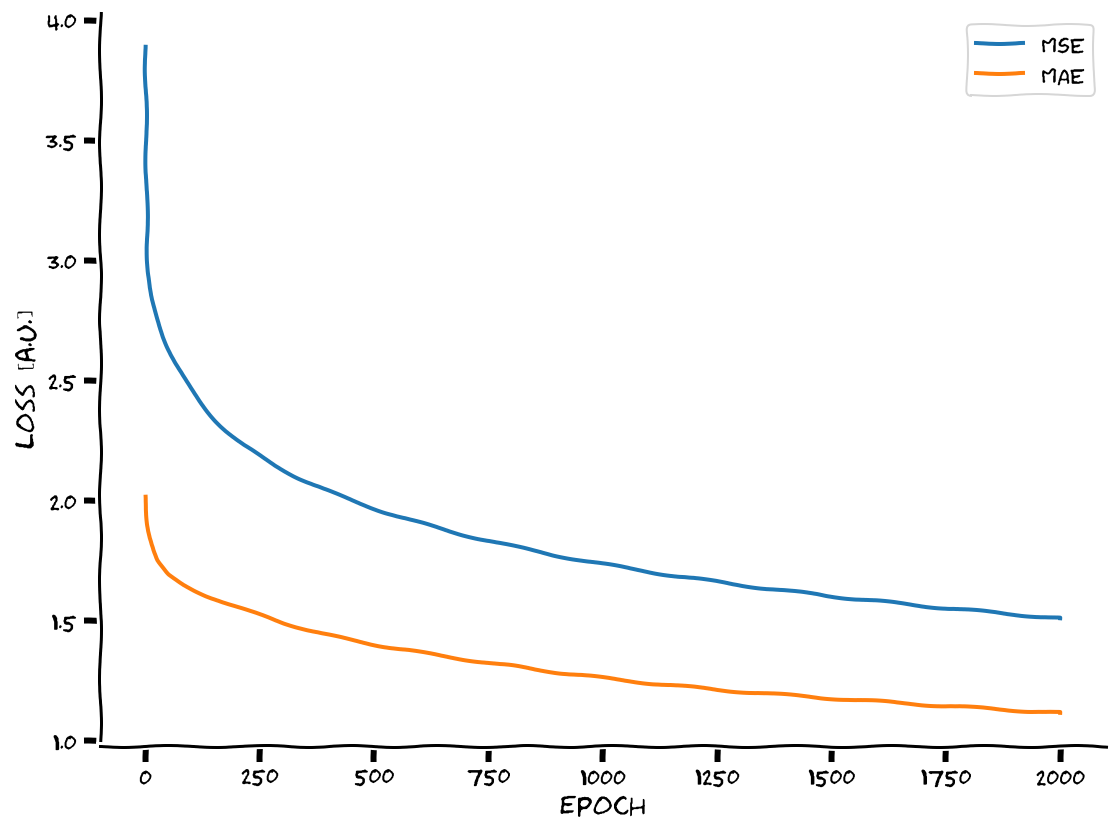


Errors in the test set using both models
Test set: using L1 loss function (MAE): 1.156540036201477
Test set: L2 loss function (MSE): 1.5591681003570557


In [ ]:
# to_remove solution

def MSEvsMAE(inputs, targets):
  # input size dimension - features
  input_dim = inputs.shape[1]
  output_dim = targets.shape[1]
  # size of the hidden layer
  hidden = [50, 10]

  learningRate = 1e-5
  epochs = 2000

  # Create the model with MAE Loss
  modelMAE = SimpleNet(input_dim, hidden, output_dim).to(device)
  criterion_mae = nn.L1Loss()  # L1 Loss - Absolute error
  optimizerMAE = torch.optim.SGD(modelMAE.parameters(), lr=learningRate)

  # Create model with MSE loss
  modelMSE = SimpleNet(input_dim, hidden, output_dim).to(device)
  criterion_mse = nn.MSELoss()
  optimizerMSE = torch.optim.SGD(modelMSE.parameters(), lr=learningRate)


  # Training Loop for both models
  print('Training...')
  lossesMAE = []
  lossesMSE = []

  epoch_range = trange(epochs, desc='MAE: vs MSE:', leave=True)
  for epoch in epoch_range:
    if lossesMAE:
      epoch_range.set_description(
          "MAE: {:.4f} vs MSE: {:.4f}".format(lossesMAE[-1], lossesMSE[-1]))
      epoch_range.refresh() # to show immediately the update
    time.sleep(0.01)

    # Clear gradient buffers because we don't want any gradient from
    # previous epoch to carry forward, dont want to cummulate gradients
    optimizerMAE.zero_grad()
    optimizerMSE.zero_grad()
    # get output from the model, given the inputs
    outputsMAE = modelMAE(inputs)
    outputsMSE = modelMSE(inputs)
    # get loss for the predicted output
    lossMAE = criterion_mae(outputsMAE, targets)
    lossMSE = criterion_mse(outputsMSE, targets)
    # get gradients w.r.t to parameters
    lossMAE.backward()
    lossMSE.backward()

    # update parameters
    optimizerMAE.step()
    optimizerMSE.step()
    lossesMAE.append(lossMAE.item())
    lossesMSE.append(lossMSE.item())
      
  return (modelMAE, modelMSE,
          criterion_mae, criterion_mse,
          lossesMAE, lossesMSE)


output = MSEvsMAE(inputs_new, targets)

MAE_test = output[2](output[0](inputs_test), targets_test)
loss_2 = output[3](output[1](inputs_test), targets_test)
RMSE_test = torch.sqrt(loss_2) # we take the square root of MSE to have 
                               # both errors in the same scale
with plt.xkcd():
  loss_comparison(output[5], output[4], RMSE_test, MAE_test)

Both algorithms (i.e., MSE loss and MAE loss) converge, however the mean loss in the test set is lower using MAE.

### Section 6.2.3 Deciding which loss function to use
If the outliers represent anomalies that are important for our peoblem and thus should be detected, then we should use **MSE**. On the other hand, if we believe that the outliers just represent corrupted/wrong data, then we should choose **MAE** as loss function.

*L1 loss* is more robust to outliers, but its derivatives are not continuous, making it inefficient to find the solution. *L2 loss* is sensitive to outliers, but gives a more stable and closed form solution (by setting its derivative to 0.)

Overall, with outliers in the dataset, an MSE (L2 Loss) cost function tries to adjust the model according to these outliers on the expense of other good-samples, since the squared-error is going to be huge for these outliers(for error > 1). On the other hand MAE (L1 Loss) cost is quite resistant to outliers.
As a result, MSE cost may result in huge deviations in some of the samples which results in reduced accuracy.

So, if we can ignore the ouliers in our dataset or we need them to be there, then we should be using a MAE loss function, on the other hand if you don’t want undesired outliers in the dataset and would like to use a stable solution then first of all you should try to remove the outliers and then use a MSE loss function (unless, performance of a model with a L2 loss function may deteriorate badly due to the presence of outliers in the dataset).

**Problems with both:** There can be cases where neither MSE nor MAE loss functions gives desirable predictions. For example, if $90%$ of observations in our data-set have true target value of $1,000$ and the remaining $10%$ have target value between $0-100$. Then a model with MAE as loss might predict $1000$ for all observations, ignoring 10% of outlier cases, as it will try to go towards *median* value. In the same case, a model using MSE would give many predictions in the range of $[0, 100]$ as it will get skewed towards outliers. Both results are undesirable in many real-wrold cases.

## Section 6.3 Cosine similarity
## where cosine similarity is often a good idea

Video available at https://youtube.com/watch?v=n8HuO8OcU34


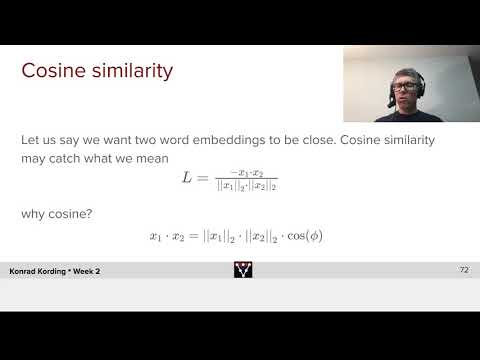

In [ ]:
#@title Video: Cosine Similarity
import time
try: t9;
except NameError: t9=time.time()

video = YouTubeVideo(id="n8HuO8OcU34", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video



On a lighter note, the embedding of a particular word (In Higher Dimension) is nothing but a vector representation of that word (In Lower Dimension). Where words with similar meaning Ex. “Joyful” and “Cheerful” and other closely related words like Ex. “Money” and “Bank”, gets closer vector representation when projected in the Lower Dimension.
The transformation from words to vectors is called `word embedding`.

Usually, in NLP application the loss function is the so-called Cosine Similarity. In mathematical terms, the cosine similarity between two vectors $x_1$ and $x_2$ is defined as:

\begin{equation}
CosineSimilarity = \frac{\left< x_1, x_2 \right>}{||x_1||_2 \cdot ||x_2||_2}
\end{equation}

where $||\cdot||_2$ denotes the *norm-2* of a vector, i.e., the length of a vector, and $\left< \cdot, \cdot \right>$ denotes the iiner product between the input vectors, i.e., $x_1^{\text{T}}x_2$.

The aforementioned equation is the definition of the Euclidean dot product between two vectors, i.e.,:

\begin{equation}
\left< x_1, x_2 \right> = ||x_1||_2 \cdot ||x_2||_2 \cdot \text{cos}(\phi)
\end{equation}

where $\phi$ is the angle between $x_1$ and $x_2$.

So the underlying concept in creating a mini word embedding boils down to train a simple linear neural network with only an input and an output layer!

Here, we will construct the training dataset with triplets of words; two of them belonging in the same sentence, and the third one in a different sentence. One training example looks like:

\begin{equation}
example = [word, same, different]
\end{equation}


We want to maximize the similarity of the words found in the same text, while minimizing the similarity with the word coming from a different sentence.

The intuition is the following:

1. Cosine similarity takes values in the range $[-1,1]$, but to minimize correlation, we want cosine to be $0$, and not $-1$.
2. We want to maximize the positive comparison ($cos(word,same)=1$) and minimize the negative comparison ($cos(word,diff)=0$)
3. The so-called *triplet margin loss* is defined as $L = d(x_1,x_2) - d(x_1,x_3) + margin$, where $d(\cdot)$ denotes a distance metric, e.g., Euclidean distance, for some arbitrary vectors $x_1, x_2, x_3$.

The loss for cosine similarity mathematically is deacribes as follows:

\begin{align}
L &{}= \left( 1-cos(word,same) - (1-cos(word,diff) \right) + margin \\
&{}= -cos(word,same) + cos(word,diff) + margin$
\end{align}

The ideal loss would be $-1 + 0 + margin$. 

Setting the $margin$ to $1$ would ensure that our loss could never be negative, but it is too aggressive, thus we usually pick a lower value, e.g., $0.5$.


In [ ]:
# Sample Document (Recreated from the tom and jerry cartoon)
        
sample_docs = ['cat and mice are buddies',
               'mice lives in hole',
               'cat lives in house',
               'cat chases mice',
               'cat catches mice',
               'cat eats mice',
               'mice runs into hole',
               'cat says bad words',
               'cat and mice are pals',
               'cat and mice are chums',
               'mice stores food in hole',
               'cat stores food in house',
               'mice sleeps in hole',
               'cat sleeps in house']

### Section 6.3.1 Constructing the dataset

Our aim is to translate each word into a vector of real numbers. Towards this goal, firt we give an index to each word, and then we transform each word into a vector with all zeros but one position equal to one (one hot encoding).

First, we assign an integer to each word in our vocabulary, which consists of all words in the text!

In [ ]:
# Make and indexing from indices to words and vice versa
idx_2_word, word_2_idx = idx_word(sample_docs)

# Total vacabulary
vocab_size = len(idx_2_word)

# Transform the indices in one hot encoding
encoded_docs = [one_hot_map(d, word_2_idx) for d in sample_docs]

# Padding for consistency (i.e., adding zeros if the length is smaller than the max length)
max_len = max([len(e) for e in encoded_docs]) + 3
padded_docs = pad_sequences(encoded_docs, maxlen=max_len, padding='post')

Then, we map each integer into one-hot encoding. For example:

\begin{align}
`and` &{} \rightarrow `1` \rightarrow [0, 1, 0, 0, 0, 0, \dots, 0] \\
`buddies` &{} \rightarrow `4` \rightarrow [0, 0, 0, 0, 1, 0, \dots, 0] 
\end{align}

In [ ]:
# Construct the training data as triplets of [word1SameSentence, word2SameSentence, word3DiffSentence]
training_data = np.empty((0,3))

for i in range(len(padded_docs)):
  sentence = padded_docs[i]
  x = sentence[np.argwhere(sentence!=0).squeeze()]
  x = np.unique(x)
  pairs = combinations(list(x))
  for comb in pairs:
    for j in range(len(padded_docs)):
      if j != i:
        sentence2 = padded_docs[j]
        y = sentence2[np.argwhere(sentence2!=0).squeeze()]
        for xi in y:
          training_data = np.append(training_data,
                                    [[comb[0], comb[1], xi]],
                                    axis=0)

# print the data shapes
print(training_data.shape)
# Shuffle the data
np.random.shuffle(training_data)
training_data = training_data

# Make the data one hot encoded
enc = OneHotEncoder()
enc.fit(np.array(range(vocab_size+1)).reshape(-1,1))
onehot_label_x1 = enc.transform(training_data[:,0].reshape(-1,1)).toarray()

enc = OneHotEncoder()
enc.fit(np.array(range(vocab_size+1)).reshape(-1,1))
onehot_label_x2 = enc.transform(training_data[:,1].reshape(-1,1)).toarray()

enc = OneHotEncoder()
enc.fit(np.array(range(vocab_size+1)).reshape(-1,1))
onehot_label_x3 = enc.transform(training_data[:,2].reshape(-1,1)).toarray()

# From Numpy to Torch
onehot_label_x1 = torch.from_numpy(onehot_label_x1)
onehot_label_x2 = torch.from_numpy(onehot_label_x2)
onehot_label_x3 = torch.from_numpy(onehot_label_x3)
print(onehot_label_x1.shape, onehot_label_x2.shape, onehot_label_x3.shape)

(5089, 3)
torch.Size([5089, 23]) torch.Size([5089, 23]) torch.Size([5089, 23])


### Section 6.3.2 Construct the model and train it

#### Exercise 9: Write the custom loss function

As we mentioned above, here we will use a modified triplet margin loss function. The input `x` in the function is a `3D` `torch.Tensor`, and it should return the average loss across `N` examples.

*Hint*: the input `x` has dimensions $(N \times L \times D)$, where $N$ denotes the number of the triplets, $L$ the number of words in the triplet (!!!), and $D$ the dimension of the embedding. You can use the `cosine_similarity` function from `torch.nn.functional` (see how we import it).

In [ ]:
def criterion(x):
  margin = 0.5
  ####################################################################
  # Fill in missing code below (...),
  # then remove or comment the line below to test your function
  raise NotImplementedError("Calculate the `mean` loss")
  ####################################################################
  loss = ...
  return loss


x = torch.randn((5, 3, 2))
print(x)
## uncomment the following line to check your function
#print(criterion(x))

tensor([[[-1.4197, -0.3795],
         [ 1.3711, -0.2059],
         [-1.5338,  0.7849]],

        [[-0.5199,  1.1867],
         [-0.9037,  0.9262],
         [-1.4454,  0.2967]],

        [[-0.7965,  0.6416],
         [-0.5797,  0.7230],
         [ 0.1540, -1.1096]],

        [[-2.8707, -0.0524],
         [ 0.3379,  0.9644],
         [-0.0094, -1.9233]],

        [[-0.7675, -0.2930],
         [-0.4431, -1.8416],
         [ 0.4175, -1.5839]]])


In [ ]:
# to_remove solution
def criterion(x):
  margin = 0.5
  loss = torch.mean(-F.cosine_similarity(x[:,0], x[:,1]) +
                    F.cosine_similarity(x[:,0], x[:,2]) +
                    margin)
  
  return loss


x = torch.randn((5, 3, 2))
print(x)
print(criterion(x))

tensor([[[ 0.2592,  1.4744],
         [-2.1578, -0.3801],
         [ 0.6966,  1.7360]],

        [[ 0.2936, -0.7969],
         [ 0.5965,  0.4266],
         [-0.8254,  1.9765]],

        [[ 0.4096, -1.9501],
         [ 0.9698,  0.2686],
         [-1.0981,  1.3729]],

        [[-0.5036, -0.0494],
         [-0.0357,  1.8499],
         [ 0.7165,  0.0589]],

        [[ 1.7083,  1.6042],
         [ 0.4887, -0.6011],
         [ 1.8209, -0.4802]]])
tensor(0.3872)


Linear(in_features=23, out_features=2, bias=True)
Epoch [10/100], Loss: 0.007396327331662178
Epoch [20/100], Loss: -0.009714988060295582
Epoch [30/100], Loss: -0.017838094383478165
Epoch [40/100], Loss: -0.022584808990359306
Epoch [50/100], Loss: -0.02566671371459961
Epoch [60/100], Loss: -0.027799593284726143
Epoch [70/100], Loss: -0.029338492080569267
Epoch [80/100], Loss: -0.03048042394220829
Epoch [90/100], Loss: -0.031344056129455566
Epoch [100/100], Loss: -0.032004911452531815


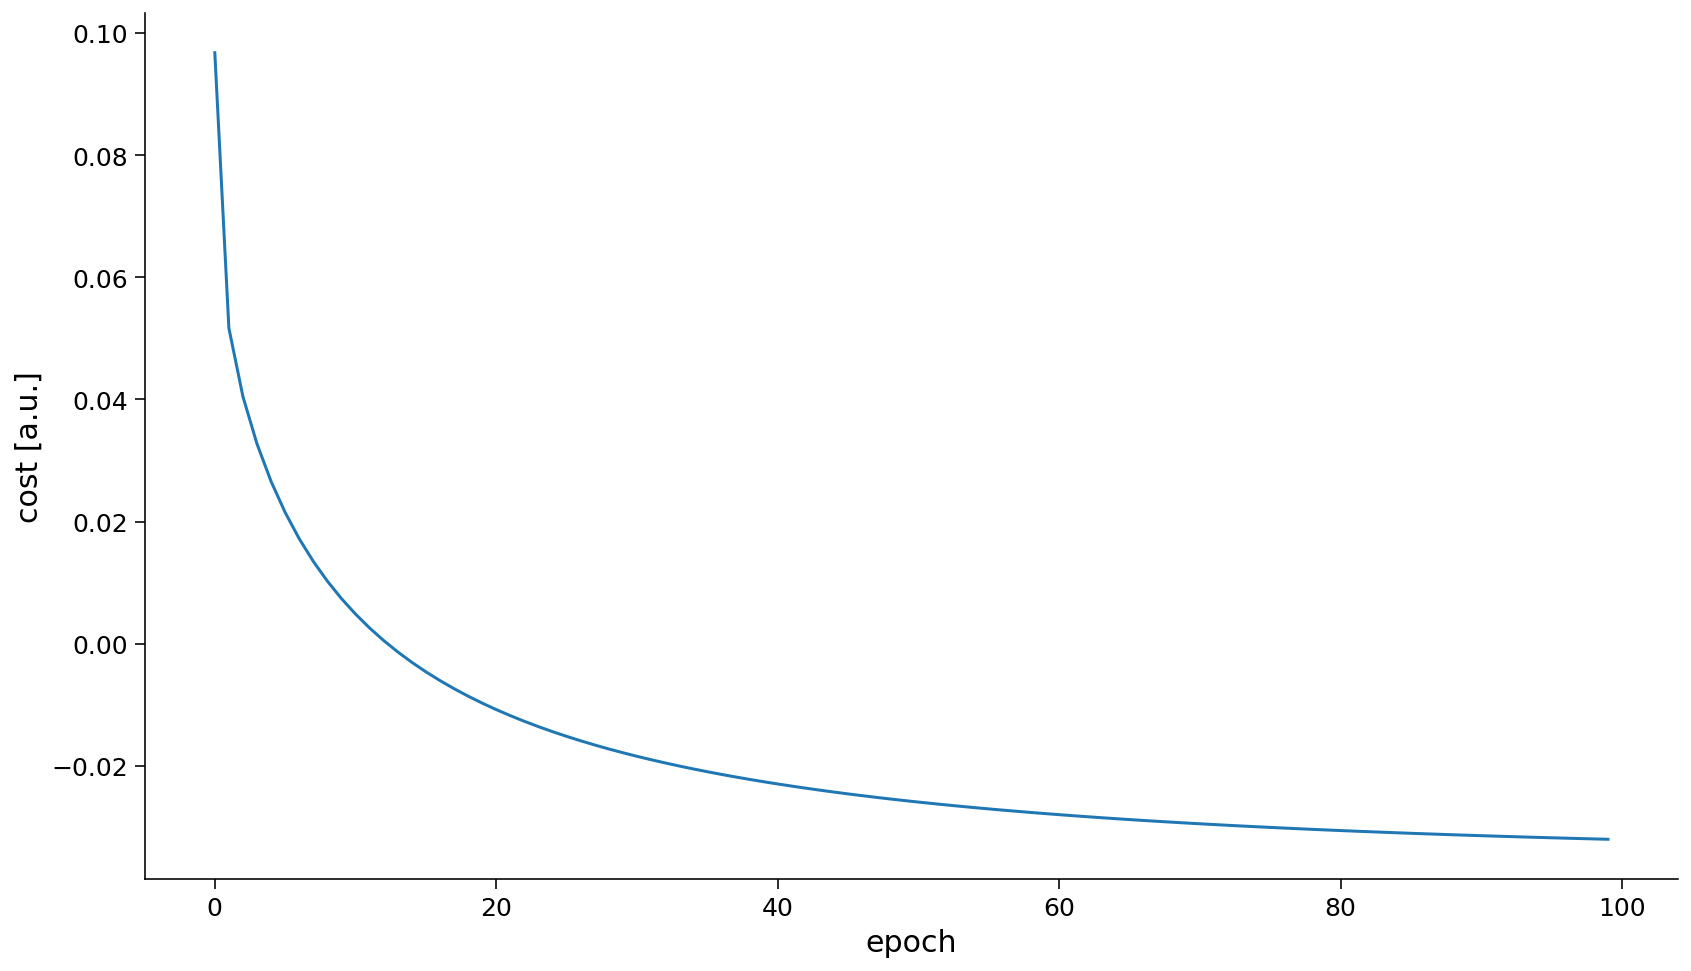

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = vocab_size + 1
hidden_size = 2
learning_rate = 0.01
num_epochs = 100
batch_size = 10

# Our simple model
net = nn.Linear(input_size, hidden_size)

# Weights initialization
sigma = 0.01
net.weight.data.normal_(0, sigma)
net.bias.data.normal_(0, sigma)

net.to(device)
net.train(True)
print(net)

# Optimizer  
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

# Training loop
loss_val = []
_data = torch.stack((onehot_label_x1, 
                     onehot_label_x2,
                     onehot_label_x3), axis=1).float().to(device)

for epoch in range(num_epochs):
  for idx in range(0, len(_data), batch_size):
    batch = _data[idx:idx+batch_size]
  
    # Forward pass
    output = net(batch.float())
    
    # Custom loss
    loss = criterion(output)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()    
  
  loss_val.append(loss.item())
  if (epoch+1) % 10 == 0:
    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

plt.figure(figsize=(12, 7))
plt.plot(loss_val)
plt.ylabel('cost [a.u.]')
plt.xlabel('epoch')
plt.show()

### Section 6.3.2: Evaluate model's performance

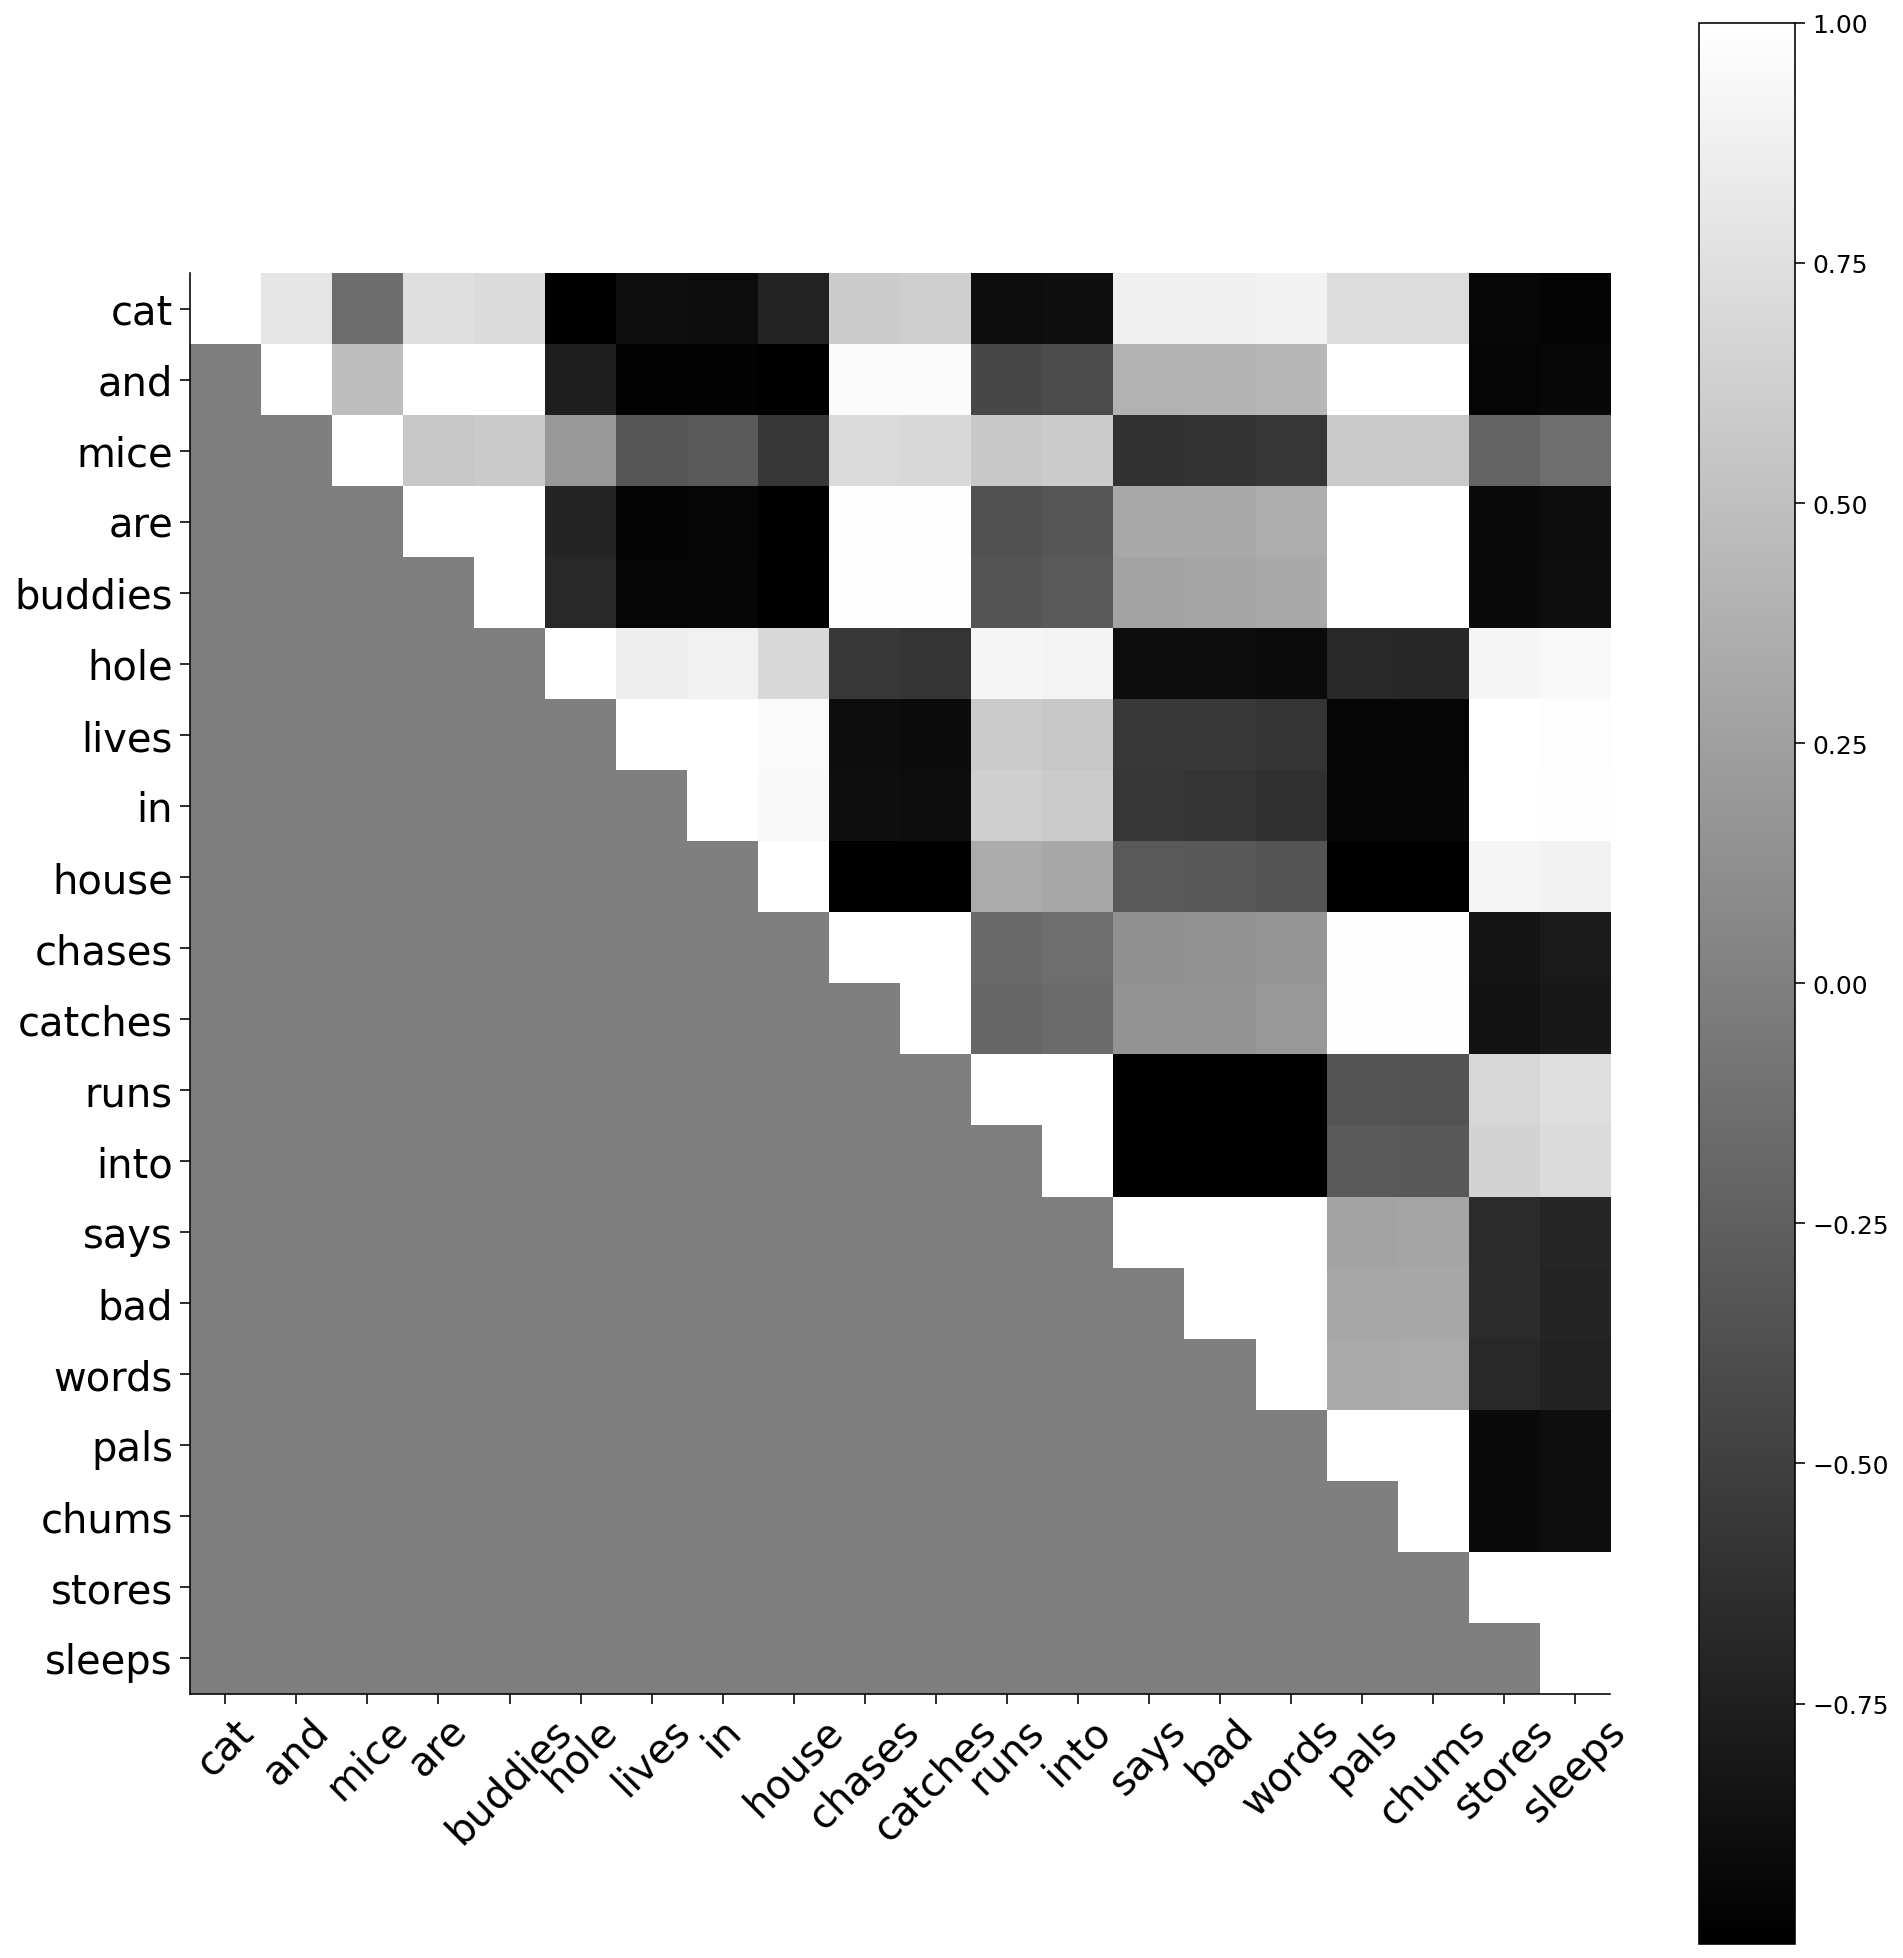

In [ ]:
docs = ['cat and mice are buddies hole lives in house chases catches runs '
        'into says bad words pals chums stores sleeps']
encoded_docs = [one_hot_map(d, word_2_idx) for d in docs]

test_arr = np.array([[ 1.,  2., 3., 4., 5., 8., 6., 7., 9., 10., 11., 13.,
                      14., 15., 16., 17., 18., 19., 20., 22.]])
test = enc.transform(test_arr.reshape(-1,1)).toarray().astype(np.float32)
test = torch.from_numpy(test).float().to(device)

docs = ['cat', 'and', 'mice', 'are', 'buddies', 'hole', 'lives',
        'in', 'house', 'chases', 'catches', 'runs', 'into', 'says', 'bad',
        'words', 'pals', 'chums', 'stores', 'sleeps']

with torch.no_grad():
  output = net(test)

# Cosine Similarity Matrix
cos = nn.CosineSimilarity(dim=0, eps=1e-6)

similarities = np.empty((len(output), len(output)))

for i in range(len(output)):
  for j in range(len(output)):
    similarities[i,j] = cos(output[i], output[j])

plt.figure(figsize=(14,14))
plt.imshow(np.triu(similarities), cmap='gray')
plt.colorbar()
plt.xticks(range(len(docs)), docs, rotation=45, fontsize=20)
plt.yticks(range(len(docs)), docs, fontsize=20)
plt.show()

[array(0.4437332, dtype=float32), array(-0.05370736, dtype=float32), array(-0.94668305, dtype=float32), array(-0.11503528, dtype=float32), array(-0.10720398, dtype=float32), array(-0.38775635, dtype=float32), array(-0.04737531, dtype=float32), array(-0.06587553, dtype=float32), array(0.09301437, dtype=float32), array(-0.15126145, dtype=float32), array(-0.18284675, dtype=float32), array(-0.38914856, dtype=float32), array(-0.3580517, dtype=float32), array(0.35677913, dtype=float32), array(0.35921827, dtype=float32), array(0.34262386, dtype=float32), array(-0.10590072, dtype=float32), array(-0.10704772, dtype=float32), array(-0.09505212, dtype=float32), array(-0.10153499, dtype=float32)] [array(-0.69046366, dtype=float32), array(-0.6405038, dtype=float32), array(-0.43202597, dtype=float32), array(-0.68760884, dtype=float32), array(-0.53541875, dtype=float32), array(0.5463044, dtype=float32), array(0.4999325, dtype=float32), array(0.51049745, dtype=float32), array(0.49054793, dtype=float32

<Figure size 576x432 with 0 Axes>

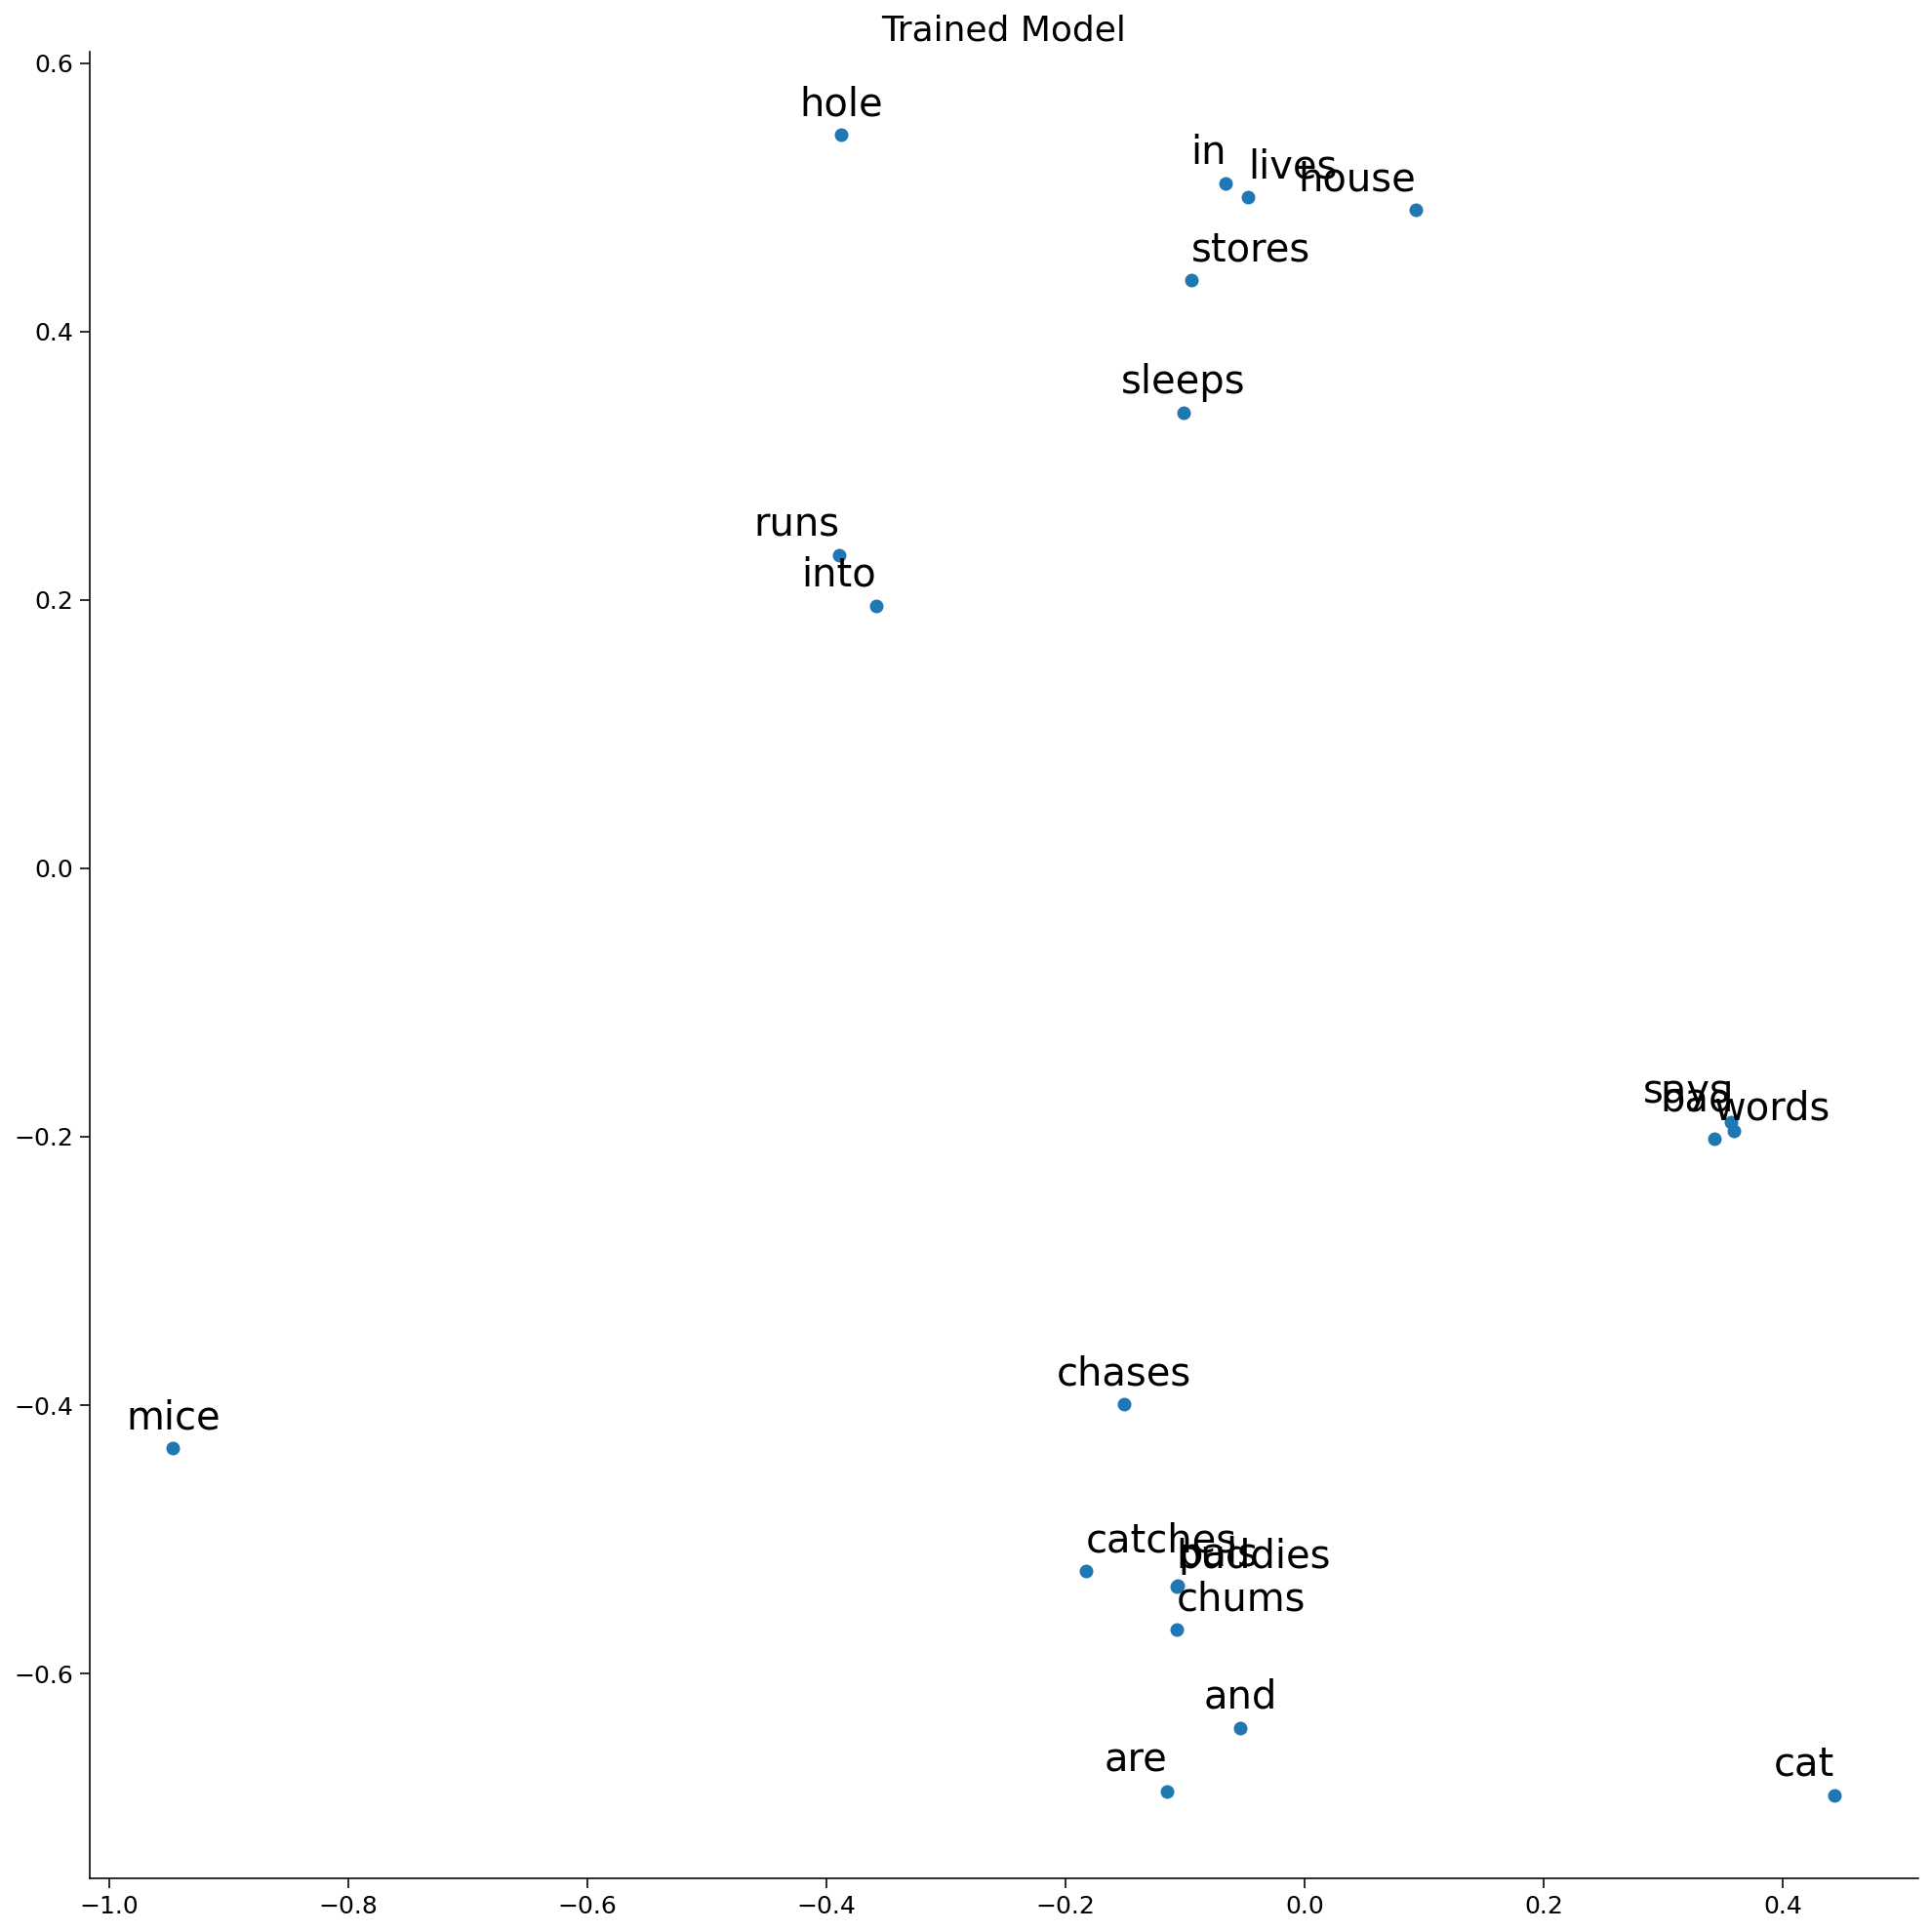

In [ ]:
xs = []
ys = []
for i in range(len(output)):
  xs.append(output[i][0].cpu().detach().numpy())
  ys.append(output[i][1].cpu().detach().numpy())
print(xs, ys)

docs = ['cat', 'and', 'mice', 'are', 'buddies', 'hole', 'lives', 'in', 'house',
        'chases', 'catches', 'runs', 'into', 'says', 'bad', 'words', 'pals',
        'chums', 'stores', 'sleeps']

plt.clf()
plt.figure(figsize=(14, 14))
plt.scatter(xs, ys)
label = docs

for i, (x, y) in enumerate(zip(xs, ys)):
  plt.annotate(label[i], (x, y), textcoords="offset points",
               xytext=(0, 10), fontsize=20,
               ha=random.choice(['left', 'right', 'center']))
  plt.title("Trained Model")
plt.show()

In the plot above, we can see how the word embeddings we learn are distributed in the $2D$ space. Notice that, `mouse` and `cat` are separated in space. In additiom, the words `buddies`, `pals`, and `chums` are close to one another. This linear embedding 'semantically' makes sense, right?

Obviously, as you will learn later in the course, there are more sophisticated NLP approaches to build a word embedding. Here, we expolore one of the simplest cases, showing also an interesting way of using the cosine similarity.

In [ ]:
#@markdown Can you think three applications where MSE, MAE, cosine similarity, respectively, can be applied?
loss_func = '' #@param {type:"string"}

---
# Section 7: High dimensional spaces intuition


Video available at https://youtube.com/watch?v=OyiHIFqJvJ0


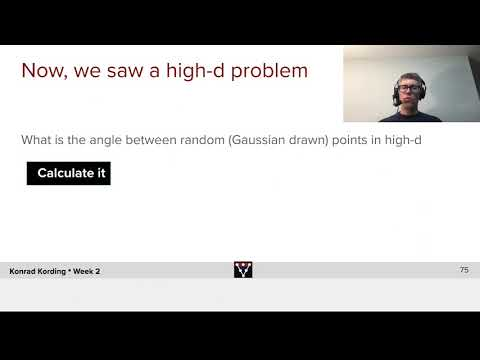

In [ ]:
#@title Video: Angle between Gaussian Drawn High Dimensional Vectors
import time
try: t10;
except NameError: t10=time.time()

video = YouTubeVideo(id="OyiHIFqJvJ0", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

Calculate the angles between two vectors sampled from an isotropic gaussian.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in arccos


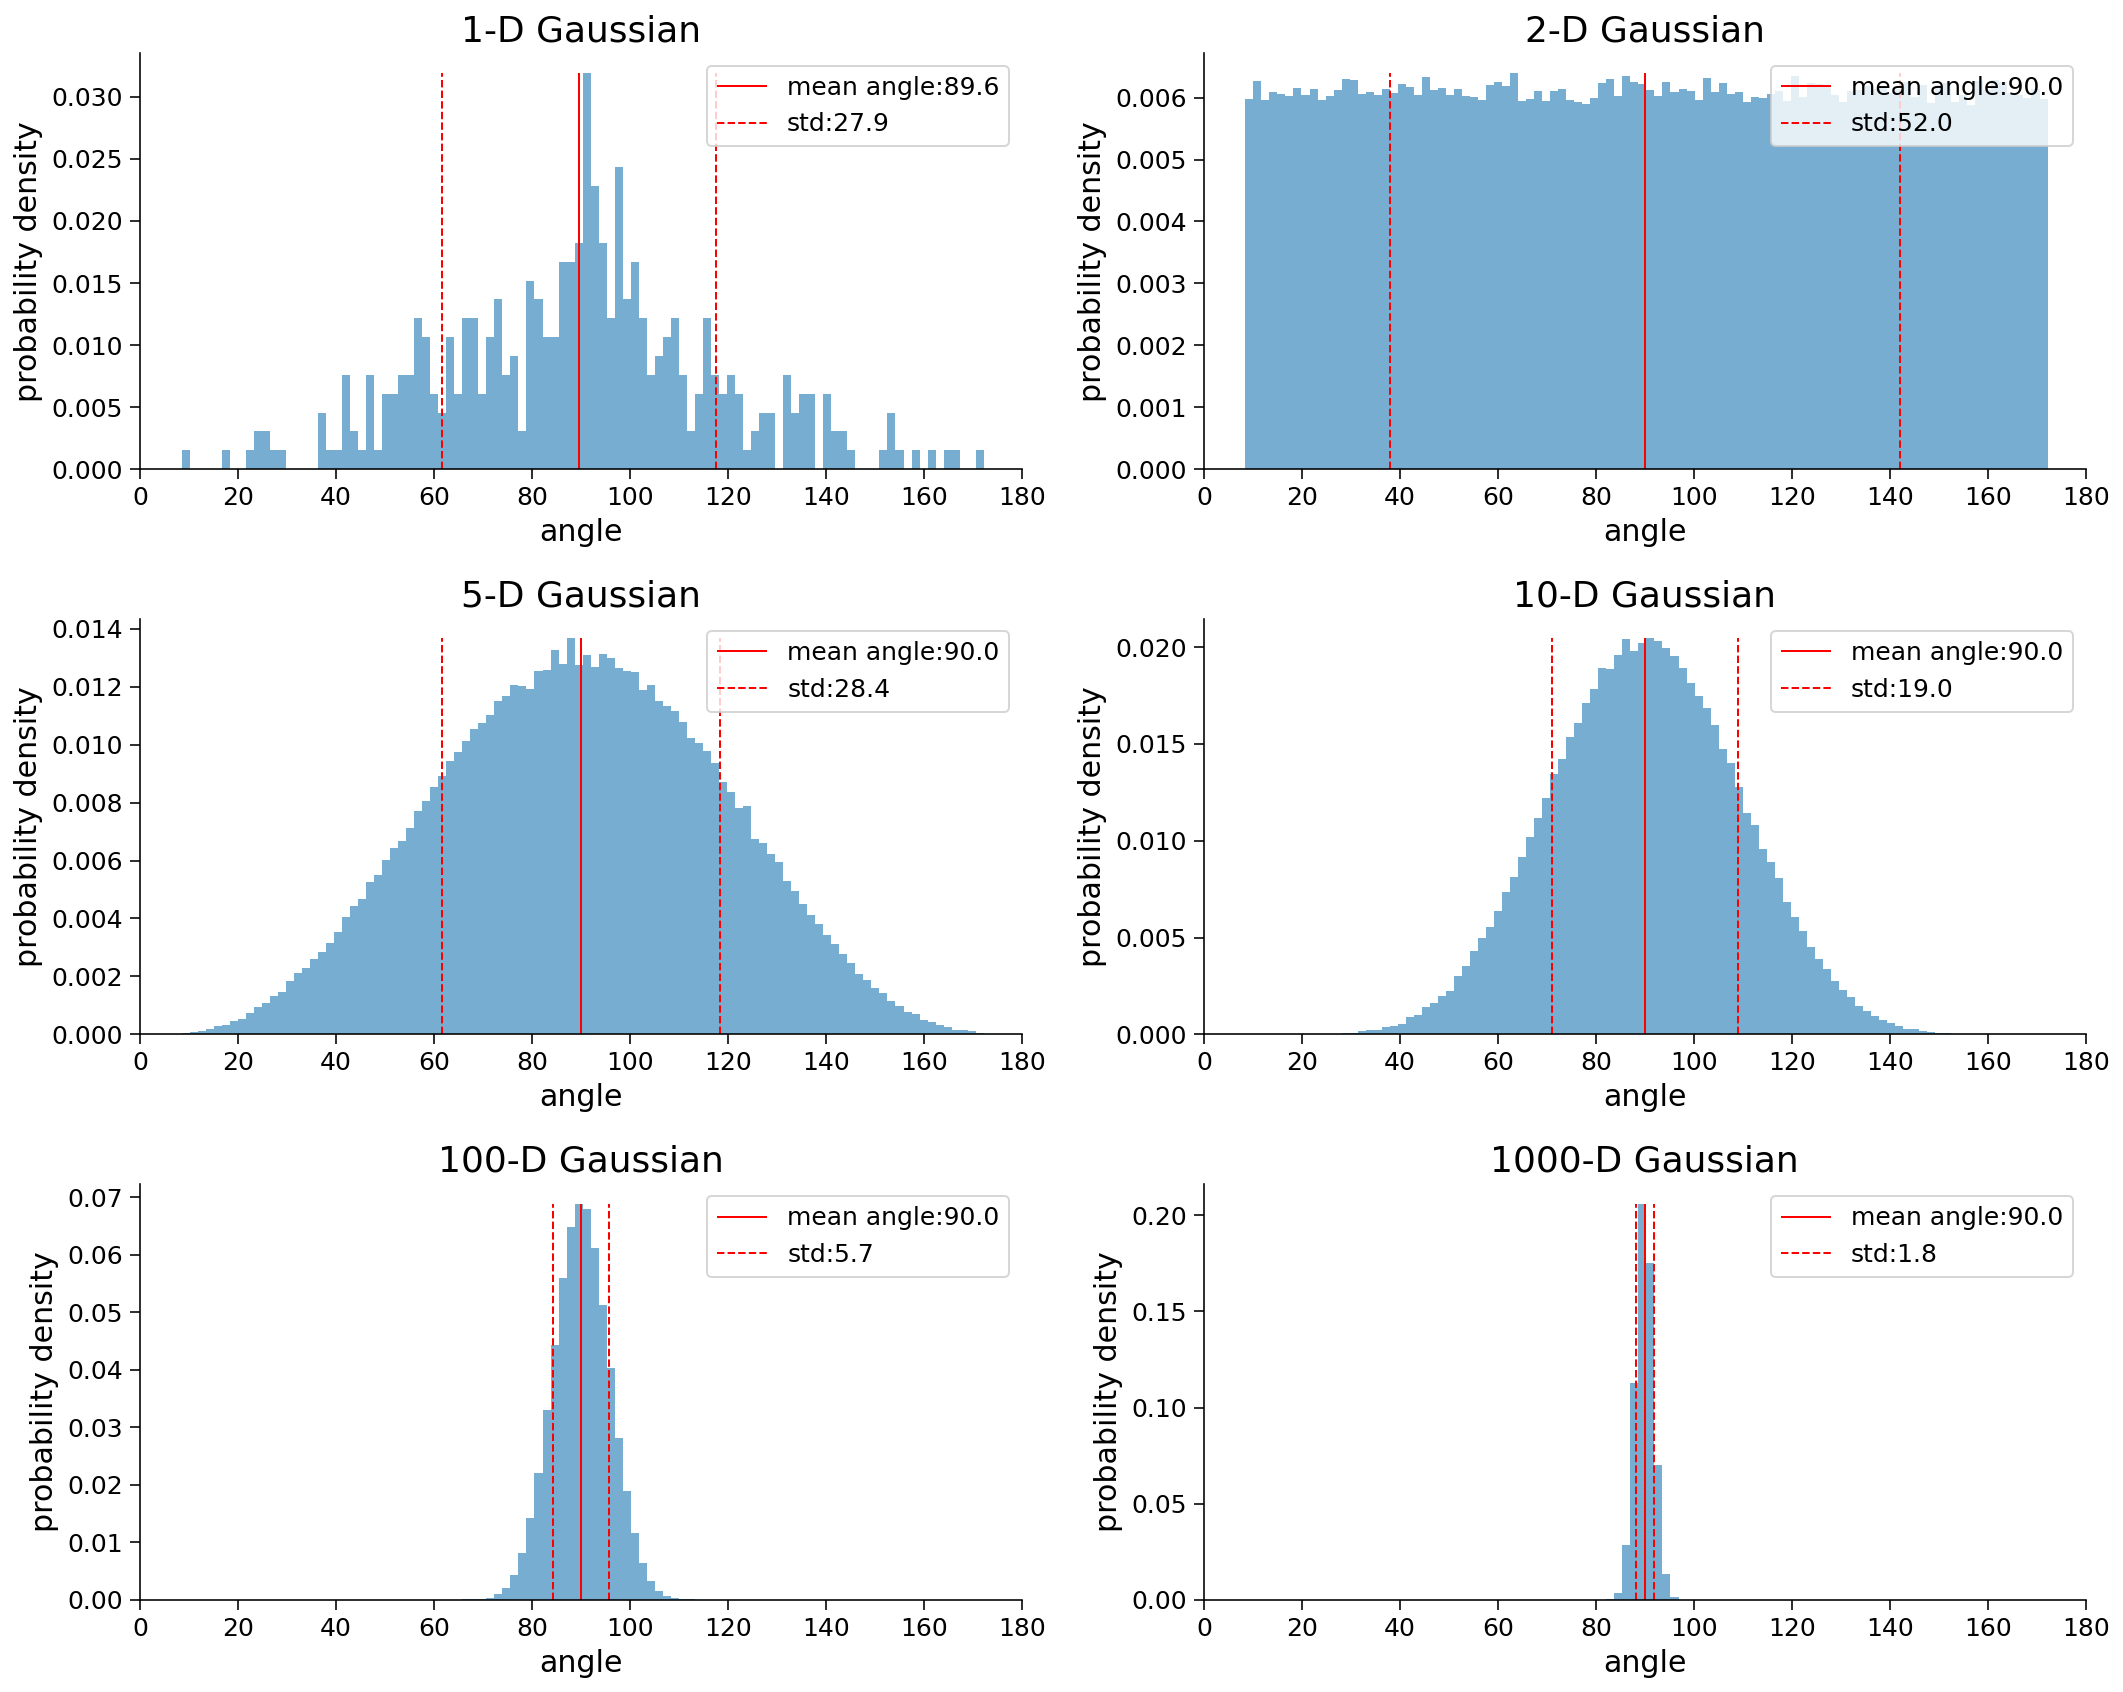

In [ ]:
sample_size = 500
cnt = 0
plt.figure(figsize=(15,12))
for D in [1, 2, 5, 10, 100, 1000]:
  cnt+=1
  angles = []
      
  if D != 1:
    mean = np.zeros(D)
    cov = 2*np.eye(D)  # diagonal covariance, i.e., isotropic gaussian
    x = np.random.multivariate_normal(mean, cov, size=sample_size).T
    x /= np.linalg.norm(x, axis=0).reshape(1,-1)
    y = np.random.multivariate_normal(mean, cov, size=sample_size).T
    y /= np.linalg.norm(y, axis=0).reshape(1,-1)
    dot_product = np.dot(x.T,y)
    angles = np.arccos(dot_product)
    angles = angles[~np.isnan(angles)]
  
  elif D == 1:
    x = np.random.randn(sample_size)
    y = np.random.randn(sample_size)
    dot_product = x*y
    angles = np.arccos(dot_product)
    angles = angles[~np.isnan(angles)]
    
  if cnt == 1:
    bins = np.histogram(np.degrees(angles), bins=100)[1]  # get the bin edges
  
  
  mean = np.round(np.mean(np.degrees(angles)), 1)
  std = np.round(np.std(np.degrees(angles)), 1)
  plt.subplot(3, 2, cnt)
  vals, bins, p = plt.hist(np.degrees(angles), bins=bins,
                           density=True, alpha=0.6)
  plt.xlabel('angle')
  plt.xlim([0, 180])
  plt.vlines(x=mean, ymin=0.0, ymax=max(vals),
             colors='red', linewidth=1.0,
             label=f'mean angle:{mean}')
  plt.vlines(x=mean-std, ymin=0.0, ymax=max(vals),
             colors='red', linewidth=1.0, linestyle='--',
             label=f'std:{std}')
  plt.vlines(x=mean+std, ymin=0.0, ymax=max(vals),
             colors='red', linewidth=1.0, linestyle='--')
  plt.ylabel('probability density')
  plt.title(f'{D}-D Gaussian')
  plt.legend()
    
plt.tight_layout()

Video available at https://youtube.com/watch?v=1p2nip3qnO0


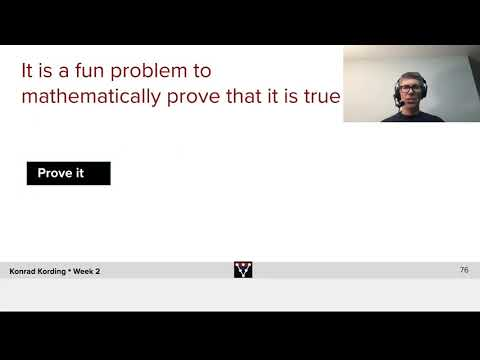

In [ ]:
#@title Video:Prove 90 Degrees
import time
try: t11;
except NameError: t11=time.time()

video = YouTubeVideo(id="1p2nip3qnO0", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## Proof of 90 degrees in high D space

Here, we want to prove that the angle between two vectors become zero as we increse the dimensions of vectors sampled from an isotropic normal distribution.

\begin{equation}
\textbf{x, y} \sim \mathcal{N}(0, \sigma I_D)
\end{equation}

where $I_D$ is the $D\times D$ identity matrix.

We want to find the expectation and the variance of the angle ($\theta$) between $\textbf{x}$ and $\text{y}$, so we need to calculate the $cos(\theta)$

We know that

\begin{equation}
\textbf{x}^{\text{T}} \textbf{y} = ||\textbf{x}||_2||\textbf{y}||_2 cos(\theta) \iff \\
cos(\theta) = \frac{\textbf{x}^{\text{T}} \textbf{y}}{||\textbf{x}||||\textbf{y}||}
\end{equation}

where $||\cdot||_2$ denotes the norm-2, or mathematically $||\textbf{x}||_2 = \sqrt{ \sum_{i=1}^Dx_i^2}$.

So, we want to find the expectation and the variance of all terms involved.

\begin{equation}
\mathbb{E}\left[ \textbf{x}^{\text{T}} \textbf{y} \right] = 0
\end{equation}

because both $\textbf{x}$ and $\textbf{y}$ are zero-mean and are uncorrelated.

Also, we know that 

\begin{equation}
\mathbb{E}\left[ || \textbf{x} ||_2 \right] = \sqrt{2} \sigma \frac{ \Gamma\left( \frac{D+1}{2} \right) } {\Gamma \left( \frac{D}{2}\right)}
\end{equation}

where $\Gamma( \cdot )$ is the [**Gamma function**](https://en.wikipedia.org/wiki/Gamma_function), $\Gamma(n) = (n-1)!$, $\Gamma \left( n + \frac{1}{2} \right) = {n - \frac{1}{2}\choose n} n! \sqrt{\pi}$

Thus, the expectation of the angle goes to zero, and the correponding angles is $90^o$. So, waht we care about here is the variance.

By definition, we know that:

\begin{equation}
Var(||\textbf{x}||_2) = \mathbb{E}\left[ ||\textbf{x}||_2^2\right] - \left( \mathbb{E}\left[ ||\textbf{x}||_2\right] \right)^2
\end{equation}

The expectation of the squared norm can be written as:

\begin{equation}
\mathbb{E}(||\textbf{x}||_2^2) = \mathbb{E}\left[ \sum_{i=1}^{D}x_i^2\right] = \sum_{i=1}^{D}\mathbb{E}\left[ x_i^2 \right] = \sum_{i=1}^{D}Var(x_i) = trace(\Sigma) = D\sigma^2
\end{equation}

as $\textbf{x}$ is zero-mean distributed.

Thus, 

\begin{equation}
Var(||\textbf{x}||_2) = D\sigma^2 - 2\sigma^2  \left( \frac{ \Gamma\left( \frac{D+1}{2} \right) } {\Gamma \left( \frac{D}{2}\right)} \right)^2
\end{equation}

In very high dimensional spaces, $\frac{D+1}{2} \approx \frac{D}{2}$ and so the formula is reduced in:

\begin{equation}
Var(||\textbf{x}||_2) = \sigma^2 (D - 2) \approx D\sigma^2 
\end{equation}

Next, we calculate the variance of the inner product:

\begin{equation}
Var(\textbf{x}^{\text{T}} \textbf{y}) = Var\left(\sum_{i=1}^{D} x_iy_i \right) = \sum_{i=1}^{D}Var(x_iy_i) = D\sigma^2
\end{equation}

Thus, the variance of the angles approaches zero as we increase dimensions, because the variance in the denominator is much higher than this in the numerator.

So, at high dimensional spaces, two random vectors are orthogonal in average.


## Distance of high dimensional vectors

Video available at https://youtube.com/watch?v=HXPZWoobWXs


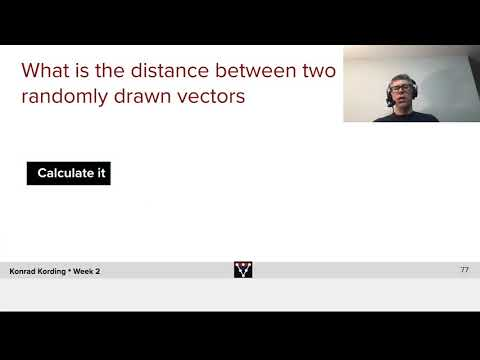

In [ ]:
#@title Video: Distance Between Gaussian Drawn High Dimensional Vectors
import time
try: t12;
except NameError: t12=time.time()

video = YouTubeVideo(id="HXPZWoobWXs", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

### Exercise 10: Plot distances in high D spaces

Now is your turn to calculate the distances in variable dimensional spaces. You may found the command `numpy.linalg.norm` useful. Execute `? np.linalg.norm` in a scratch cell to see its DocString.

In [ ]:
def plot_distances(sample_size):

  cnt = 0
  plt.figure(figsize=(15, 12))
  for D in [1, 2, 5, 10, 100, 1000]:
    cnt+=1
    norms = []
        
    if D != 1:
      mean = np.zeros(D)
      cov = 2*np.eye(D)  # diagonal covariance, i.e., isotropic gaussian
      x = np.random.multivariate_normal(mean, cov, size=sample_size).T
      x /= np.linalg.norm(x, axis=0).reshape(1,-1)
      y = np.random.multivariate_normal(mean, cov, size=sample_size).T
      y /= np.linalg.norm(y, axis=0).reshape(1,-1)
      ####################################################################
      # Fill in missing code below (...),
      # then remove or comment the line below to test your function
      raise NotImplementedError("Calculate the distance in D>2 spaces")
      ####################################################################
      norms = ...
    
    elif D == 1:
      x = np.random.randn(sample_size)
      y = np.random.randn(sample_size)
      ####################################################################
      # Fill in missing code below (...),
      # then remove or comment the line below to test your function
      raise NotImplementedError("Calculate the distance in 1D space")
      ####################################################################
      norms = ...
    
    if cnt==1:
      bins=np.histogram(norms, bins=100)[1]  # get the bin edges
    plt.subplot(3,2,cnt)
    plt.hist(norms, bins=bins, density=True, alpha=0.5)
    if D==1:
      plt.xlabel('x-y')
    else:
      plt.xlabel('||x-y||')

    plt.ylabel('probability density')
    plt.title(f'{D}-D Gaussian')
      
  plt.tight_layout()

## uncomment the line below to test your function
#sample_size = 500
#plot_distances(sample_size)

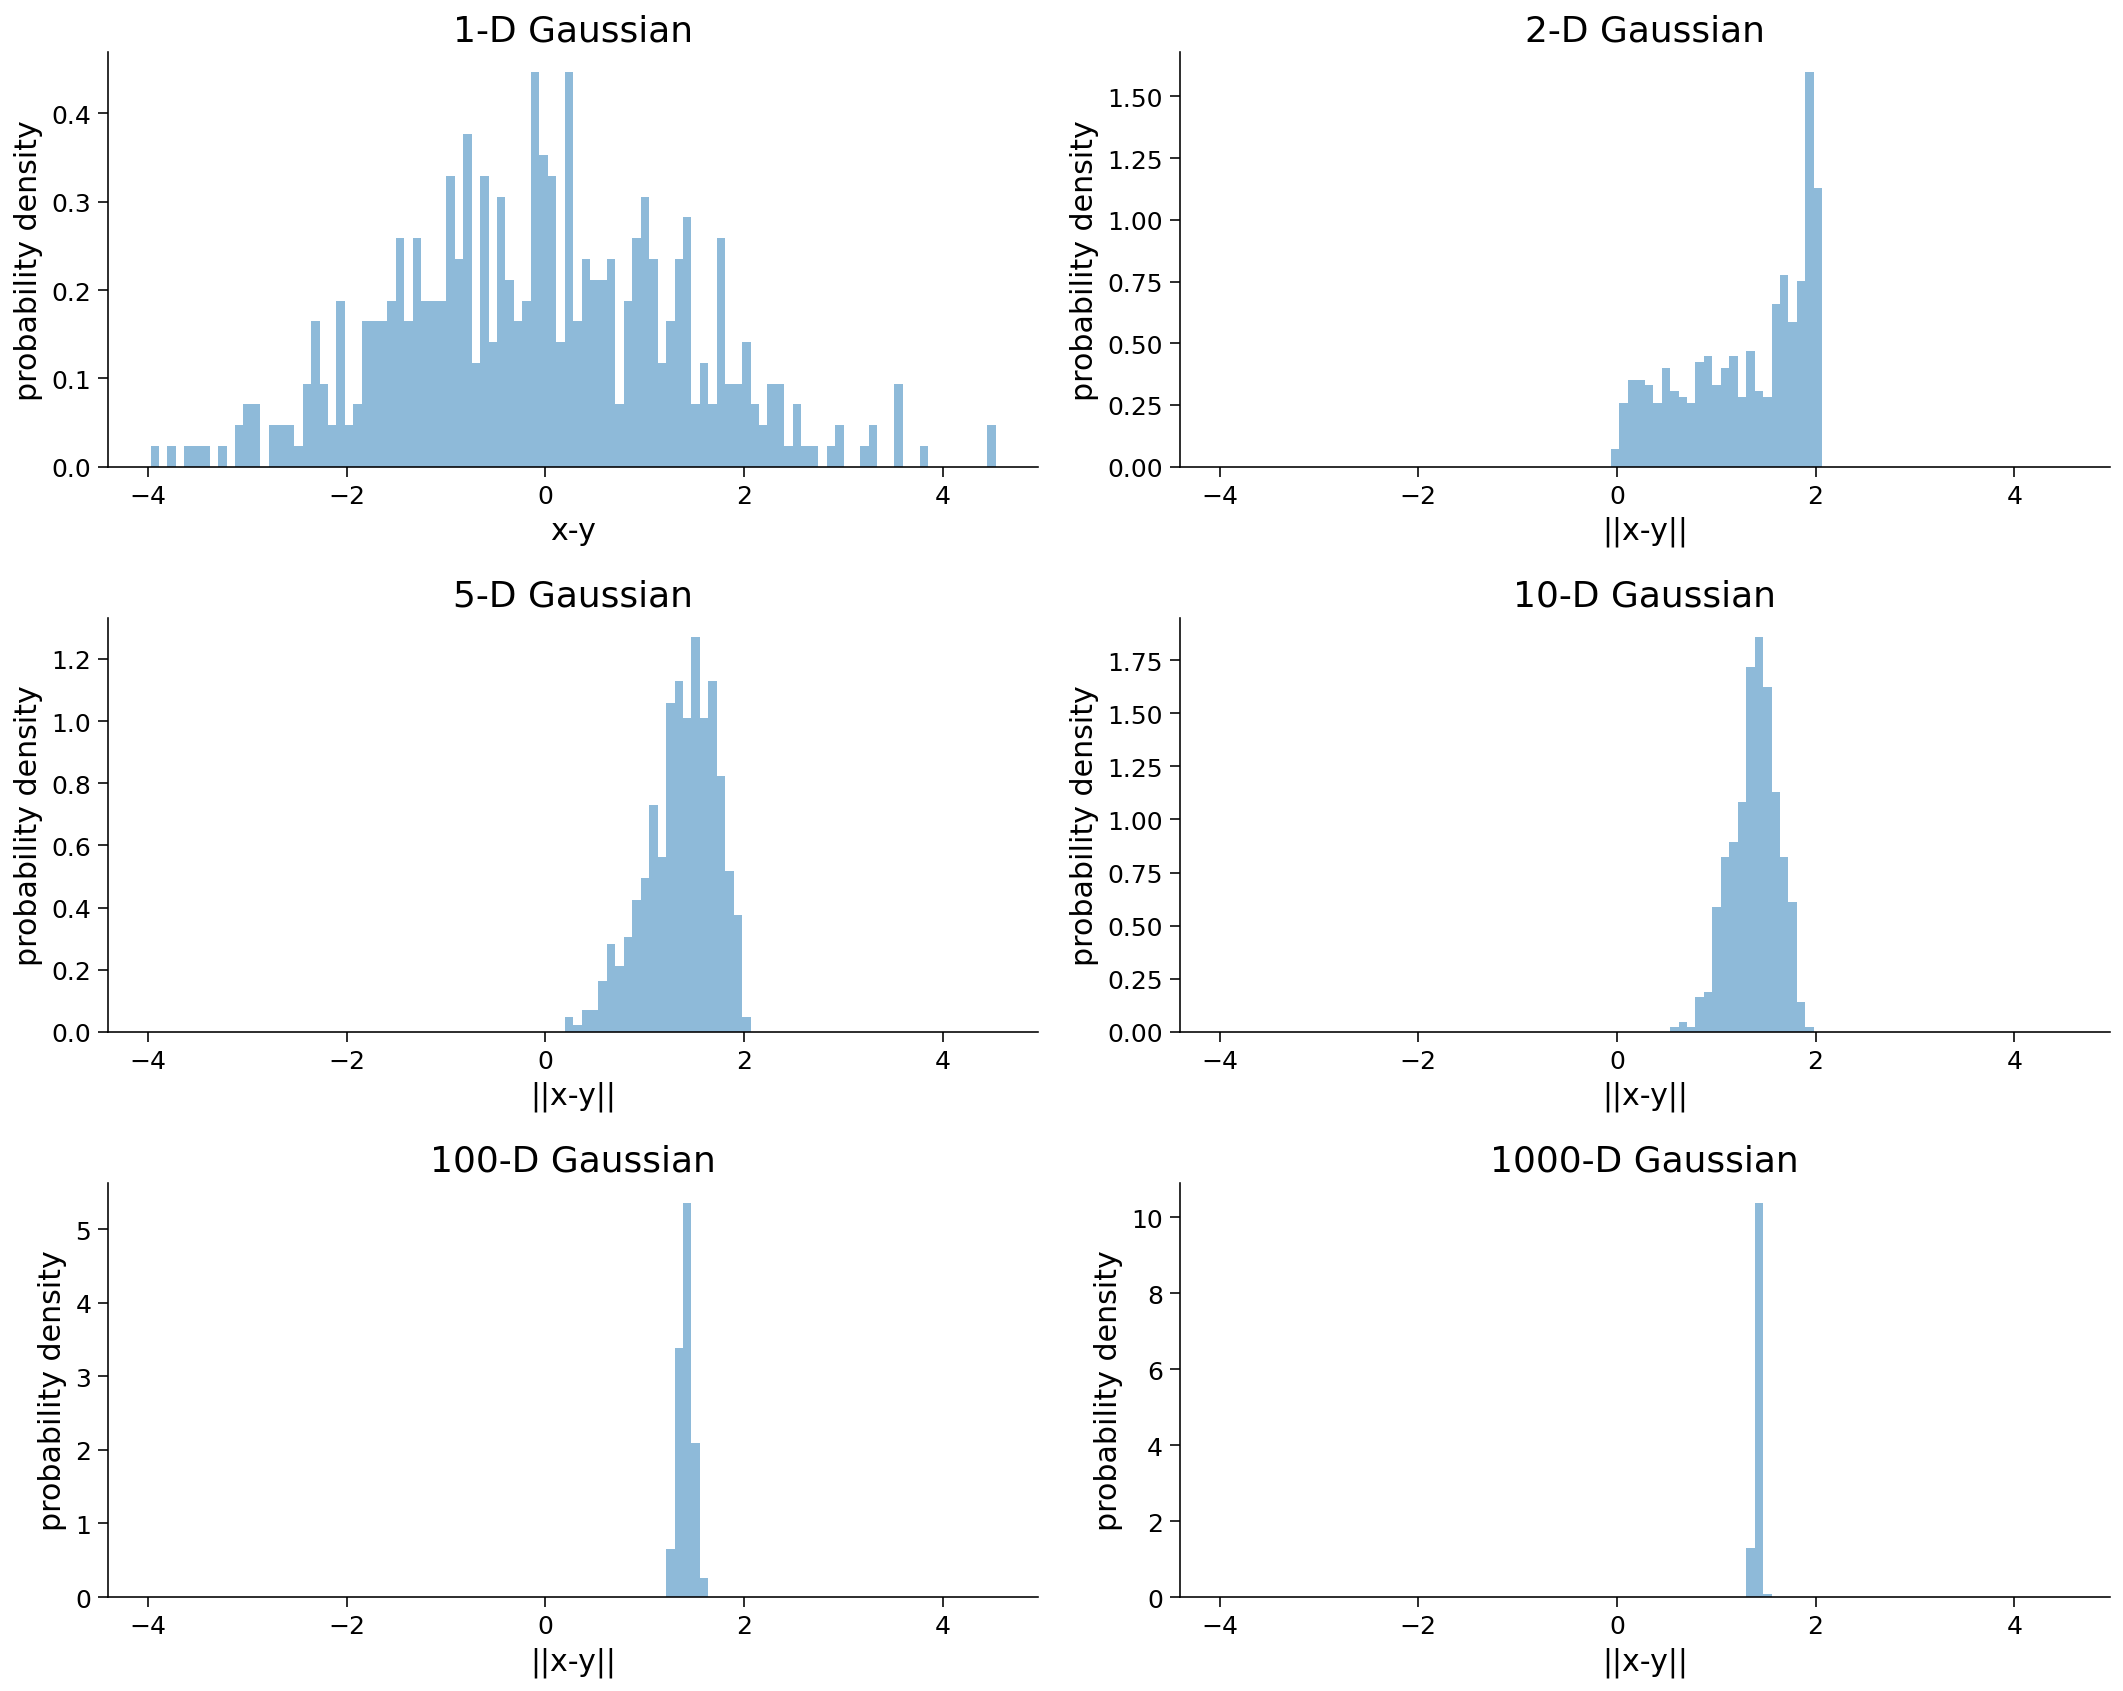

In [ ]:
# to_remove solution

def plot_distances(sample_size):

  cnt = 0
  plt.figure(figsize=(15, 12))
  for D in [1, 2, 5, 10, 100, 1000]:
    cnt+=1
    norms = []
        
    if D != 1:
      mean = np.zeros(D)
      cov = 2*np.eye(D)  # diagonal covariance, i.e., isotropic gaussian
      x = np.random.multivariate_normal(mean, cov, size=sample_size).T
      x /= np.linalg.norm(x, axis=0).reshape(1,-1)
      y = np.random.multivariate_normal(mean, cov, size=sample_size).T
      y /= np.linalg.norm(y, axis=0).reshape(1,-1)
      norms = np.linalg.norm(x-y, axis=0, ord=2)
    
    elif D == 1:
      x = np.random.randn(sample_size)
      y = np.random.randn(sample_size)
      norms = x - y
    
    if cnt==1:
      bins=np.histogram(norms, bins=100)[1]  # get the bin edges
    plt.subplot(3,2,cnt)
    plt.hist(norms, bins=bins, density=True, alpha=0.5)
    if D==1:
      plt.xlabel('x-y')
    else:
      plt.xlabel('||x-y||')

    plt.ylabel('probability density')
    plt.title(f'{D}-D Gaussian')
      
  plt.tight_layout()


sample_size = 500
plot_distances(sample_size)

---
# Wrap up: Linear Neural Networks

Video available at https://youtube.com/watch?v=uXIH35VZDis


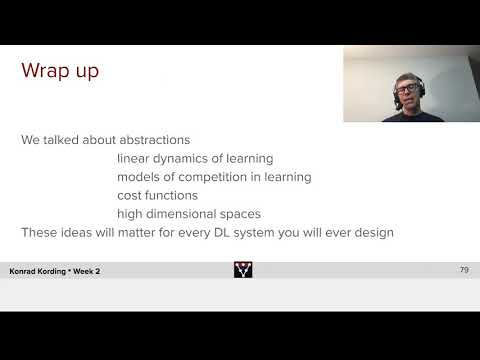

In [ ]:
#@title Video: Wrap up
import time
try: t13;
except NameError: t13=time.time()

video = YouTubeVideo(id="uXIH35VZDis", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

---
# Feedback
How could this session have been better? How happy are you in your group? How do you feel right now?

In [ ]:
import time
from IPython.display import IFrame
#@markdown #Run Cell to Show Airtable Form
#@markdown ##**Confirm your answers and then click "Submit"**

def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefills = "&".join(["prefill_%s=%s"%(key, fields[key]) for key in fields])
  src = src + prefills
  src = "+".join(src.split(" "))
  return src


#autofill time if it is not present
try: t0;
except NameError: t0 = time.time()
try: t1;
except NameError: t1 = time.time()
try: t2;
except NameError: t2 = time.time()
try: t3;
except NameError: t3 = time.time()
try: t4;
except NameError: t4 = time.time()
try: t5;
except NameError: t5 = time.time()
try: t6;
except NameError: t6 = time.time()
try: t7;
except NameError: t7 = time.time()
try: t8;
except NameError: t8 = time.time()
try: t8;
except NameError: t8 = time.time()
try: t9;
except NameError: t9 = time.time()
try: t10;
except NameError: t10 = time.time()
try: t11;
except NameError: t11 = time.time()
try: t12;
except NameError: t12 = time.time()
try: t13;
except NameError: t13 = time.time()


#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""
try: my_pod;
except NameError: my_pod = "Select"
try: sequential;
except NameError: sequential = ""
try: xor;
except NameError: xor = ""
try: xor_solution;
except NameError: xor_solution = ""
try: learning_modes;
except NameError: learning_modes = ""
try: loss_func;
except NameError: loss_func = ""

times = [(t-t0) for t in [t1,t2,t3,t4,t5,t6,t7,t8]]

fields = {"pennkey": my_pennkey,
          "pod": my_pod,
          "sequential": sequential,
          "xor": xor,
          "autograd_uses": autograd_uses,
          "xor_solution": xor_solution,
          "learning_modes": leaning_modes,
          "loss_func": loss_func}

src = "https://airtable.com/embed/shrLlXqT8QQdEk728?"

#now instead of the original source url, we do: src = prefill_form(src, fields)
display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))